# Spaceship Titanic

## Introduction

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

The aim of our work is to predict which passengers are transported to an alternate dimension, I will try to find main points which contributes to the risk of being transported to the alternative dimension while traveling with Spaceship Titanic.

Project is divided into separate parts:
<ul>
    <li>Introduction</li>
    <li>Notebook Preparation</li>
    <li>Data Cleaning</li>
    <li>Feature engineering</li>
    <li>Exploratory Data Analysis</li>
    <li>Missing Values - Feature Engineering</li>
    <li>Modelling</li>
    <li>Final Model</li>
    <li>AutoML Model</li>
    <li>Summary</li>
    <li>Suggestion For Improvement</li>
</ul>

The project consists of 3 .csv files:
<ul>
    <li><b>train.csv</b> - Personal records for about two-thirds (~8700) of the passengers, to be used as training data</li>
    <li><b>test.csv</b> - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.</li>
    <li><b>sample_submission.csv</b> - A submission file in the correct format</li>
</ul>

Train and test .csv files have these columns:
<ul>
    <li><b>PassengerId</b> -  A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.</li>
    <li><b>HomePlanet</b> - The planet the passenger departed from, typically their planet of permanent residence.</li>
    <li><b>CryoSleep</b> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</li>
    <li><b>Cabin</b> - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. To be more clear, Port is left side of the ship while Starboard is right.</li>
    <li><b>Destination</b> - The planet the passenger will be debarking to.</li>
    <li><b>Age</b> - The age of the passenger.</li>
    <li><b>VIP</b> - Whether the passenger has paid for special VIP service during the voyage.</li>
    <li><b>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</b> - Amount the passenger has billed for each of the Spaceship Titanic's many luxury amenities.</li>
    <li><b>Name</b> - The first and last names of the passenger.</li>
    <li><b>Transported</b> - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.</li>
</ul>

Sample_submission file have 2 columns:
<ul>
    <li><b>PassengerId</b> - ID for each passenger in the test set.</li>
    <li><b>Transported</b> - The target. For each passenger, predict either True or False.</li>
</ul>

## Notebook Preparation

In this section we will prepare our notebook by importing necessary libraries and setting up custom styles.

In [1]:
%matplotlib inline
# Standart libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import h2o
import joblib

# 3d-party libraries
from typing import List
from boruta import BorutaPy
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from h2o.automl import H2OAutoML
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

# Custom functions made for project
from functions.helpers import cm_matrix, split_and_insert, fill_missing_values_using_method
from functions.machine_learning_models import ml_models, ml_models_parameters

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Notebook styles
sns.set(style="darkgrid", palette="pastel")
palette_cmap = sns.color_palette("mako", as_cmap=True)
plt.rcParams['figure.figsize'] = [14, 6]

In [3]:
# Loading train data
data_train = pd.read_csv("data/train.csv")

# Loading test data
data_test = pd.read_csv("data/test.csv")

## Data Cleaning

In data cleaning part we will check our data quality, duplicate values or missing ones, which can lead to poor machine learning model performance. And dice what we will do with any of these problems. We also combine missing values filling part with data engineering, as we use knowledge from EDA to create additional columns and fill missing values.

As we know our data is already split to 2 separate files, so we will check both of the files.

In [4]:
print(f"Train dataset shape: {data_train.shape}")
print(f"Train dataset shape: {data_test.shape}")

Train dataset shape: (8693, 14)
Train dataset shape: (4277, 13)


We have 8693 rows of data in train dataset and 4277 rows for train dataset. Both datasets consist of same columns, except train which have additional column which tells if person was transported by void.

Next we can check duplicate values of both datasets, as we know PassengerId is unique for a person, so we can join both datasets only using this column to check if any duplicates appear across ID.

In [5]:
joined_data = pd.concat([data_train, data_test])
print(f"Duplicate values accros both datasets: {joined_data.duplicated().sum()}")

Duplicate values accros both datasets: 0


There are no duplicate values in datasets, we can check missing values.

In [6]:
combined_missing_values = pd.concat(
    [
        pd.DataFrame(data_train.isnull().sum()).T, 
        pd.DataFrame(data_test.isnull().sum()).T
    ], 
    keys=["Train", "Test"]
)

combined_missing_values

,,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
Train,0,0,201,217,199,182,179,203,181,183,208,183,188,200,0.0
Test,0,0,87,93,100,92,91,93,82,106,98,101,80,94,NaN


As we can see, almost all of our features in both datasets consists of missing values. It is very important to deal with them, we will come back to this later after we get ideas hot to fill it.

Next step is to check data types.

In [7]:
pd.DataFrame(data_train.dtypes).T

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,object,object,object,object,object,float64,object,float64,float64,float64,float64,float64,object,bool


Some of our columns are object type, these columns can give us information about separate groups, so we can bin our data, create additional columns if possible. 

Lastly to be sure we will check unique values in columns, this will be good indicator which columns can be split. To begin we will first change some column datatype.

In [8]:
data_train = data_train.astype({col: 'string' for col in data_train.select_dtypes(include=['object', 'bool']).columns})
data_test = data_test.astype({col: 'string' for col in data_test.select_dtypes(include=['object', 'bool']).columns})

After column data type transformation, we can split columns to create new ones.

In [9]:
pd.DataFrame(data_train.nunique()).T

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,8693,3,2,6560,3,80,2,1273,1507,1115,1327,1306,8473,2


In [10]:
data_train.head(1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False


<li>CryoSleep, VIP and Transported can be changed into 0 and 1.</li>

<li>Split PassengerId: GroupId and GroupNumber.</li>

<li>Split Cabin into: Deck, Cabin_Number, Side.</li>

<li>Split Name into FirstName and LastName.</li>

In [11]:
# Splitting columns
data_train = split_and_insert(df=data_train, split_col="PassengerId", new_cols=["GroupId", "GroupSize"], spliter="_")
data_train = split_and_insert(df=data_train, split_col="Cabin", new_cols=["Deck", "CabinNumber", "Side"], spliter="/")
data_train = split_and_insert(df=data_train, split_col="Name", new_cols=["FirstName", "LastName"], spliter=" ")

data_test = split_and_insert(df=data_test, split_col="PassengerId", new_cols=["GroupId", "GroupSize"], spliter="_")
data_test = split_and_insert(df=data_test, split_col="Cabin", new_cols=["Deck", "CabinNumber", "Side"], spliter="/")
data_test = split_and_insert(df=data_test, split_col="Name", new_cols=["FirstName", "LastName"], spliter=" ")

# Droping columns
data_train = data_train.drop(columns=["PassengerId", "Cabin", "Name", "FirstName"])
data_test = data_test.drop(columns=["PassengerId", "Cabin", "Name", "FirstName"])

# Map values True 1 and False 0
data_train["CryoSleep"] = data_train["CryoSleep"].map({"True": 1, "False": 0})
data_train["VIP"] = data_train["VIP"].map({"True": 1, "False": 0})
data_train["Transported"] = data_train["Transported"].map({"True": 1, "False": 0})

data_test["CryoSleep"] = data_test["CryoSleep"].map({"True": 1, "False": 0})
data_test["VIP"] = data_test["VIP"].map({"True": 1, "False": 0})

# Change column data type
data_train["CabinNumber"] = data_train["CabinNumber"].astype(float)
data_train["Age"] = data_train["Age"].round().astype(float)
data_train["Transported"] = data_train["Transported"].astype(int)

data_test["CabinNumber"] = data_test["CabinNumber"].astype(float)
data_test["Age"] = data_test["Age"].round().astype(float)

### Data Cleaning Summary

<ul>
    <li>No duplicate values in our datasets.</li>
    <li>We have missing values in both train and test datasets.</li>
    <li>PassengerId was separated to GroupId and GroupSize</li>
    <li>Cabin was seperated into: Deck, CabinNumber and Side.</li>
    <li>Features Home Planet and Cabin can later be split into separate columns, corresponding unique values.</li>
    <li>Features Cryo Sleep, VIP and Transported were changed into 0 and 1.</li>
</ul>

## Feature Engineering 

Base by simple view of our dataset, we can already create some additional columns, which can help us.

In [12]:
# Total spendings
features_spendings = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# New columns: how much money person spend, group spend and if people spend money or not, 
# these values will help us to fill other features.
data_train["TotalSpending"] = data_train[features_spendings].sum(axis=1)
data_train["SpentMoney"] = (data_train["TotalSpending"] > 0).astype(int)
data_train["GroupSpentMoney"] = data_train.groupby("GroupId")["SpentMoney"].transform('max')

data_test["TotalSpending"] = data_test[features_spendings].sum(axis=1)
data_test["SpentMoney"] = (data_test["TotalSpending"] > 0).astype(int)
data_test["GroupSpentMoney"] = data_test.groupby("GroupId")["SpentMoney"].transform('max')

## Exploratory Data Analysis

To avoid overfitting and data leakage, we will explore only train dataset, later when we will perform feature engineering, so we will consider test dataset also. 

We will go through features and gather more insights, which will also help us fill missing values later and create new features. 

<b>Basic Statistics</b>

In [13]:
data_train.describe()

,CryoSleep,CabinNumber,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpending,SpentMoney,GroupSpentMoney
count,8476.000000,8494.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.358306,600.367671,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,1440.866329,0.579777,0.741631
std,0.479531,511.867226,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,2803.045694,0.493623,0.437763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,167.250000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,427.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,716.000000,1.000000,1.000000
75%,1.000000,999.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,1441.000000,1.000000,1.000000
max,1.000000,1894.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,35987.000000,1.000000,1.000000


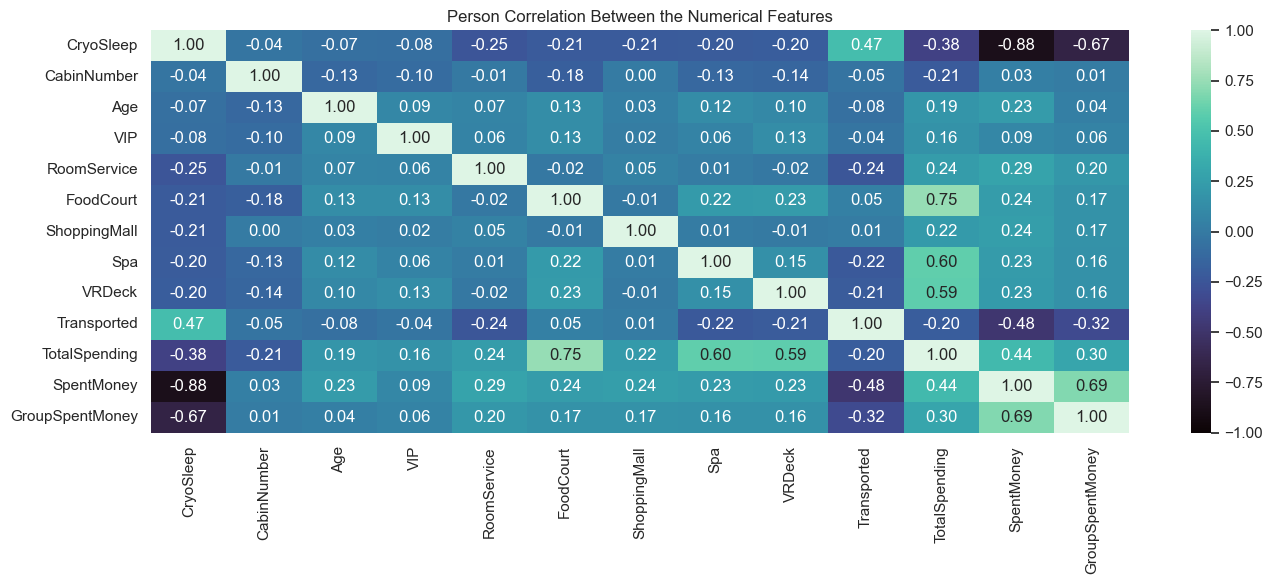

In [14]:
corr = data_train.select_dtypes(include=["float64", "int32"]).corr()

# Plot
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap=palette_cmap)
plt.title("Person Correlation Between the Numerical Features")
plt.tight_layout()
plt.show()

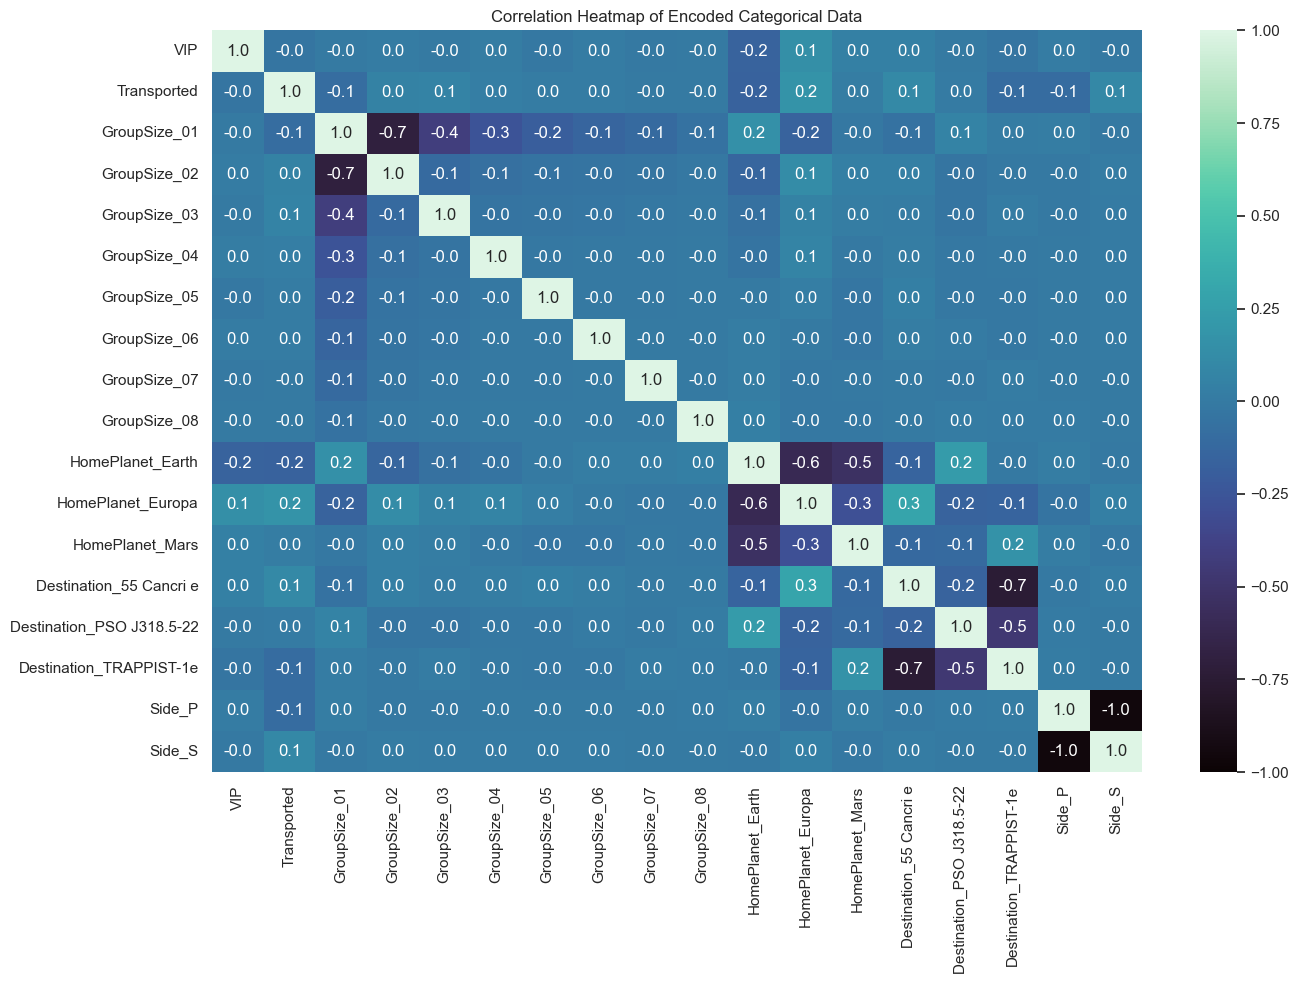

In [15]:
df_encoded = pd.get_dummies(data_train[["GroupSize", "HomePlanet", "Destination", "Side", "VIP", "Transported"]])

plt.figure(figsize=(14,10))
corr = df_encoded.corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".1f", cmap=palette_cmap)
plt.title("Correlation Heatmap of Encoded Categorical Data")
plt.tight_layout()
plt.show()

Numeric features show low to medium correlation, as we add new column which help us to fill missing values later, we will remove them, we consider to leave Total Spending as it have moderate correlation and is not big to be a problem for ML model. For categorical features, we can see it don't have any big correlation with target feature Transported. We have correlation with group size, Home Planet and Destination, but they're not impacting Transported, we will consider dealing with these features if model performs bad.

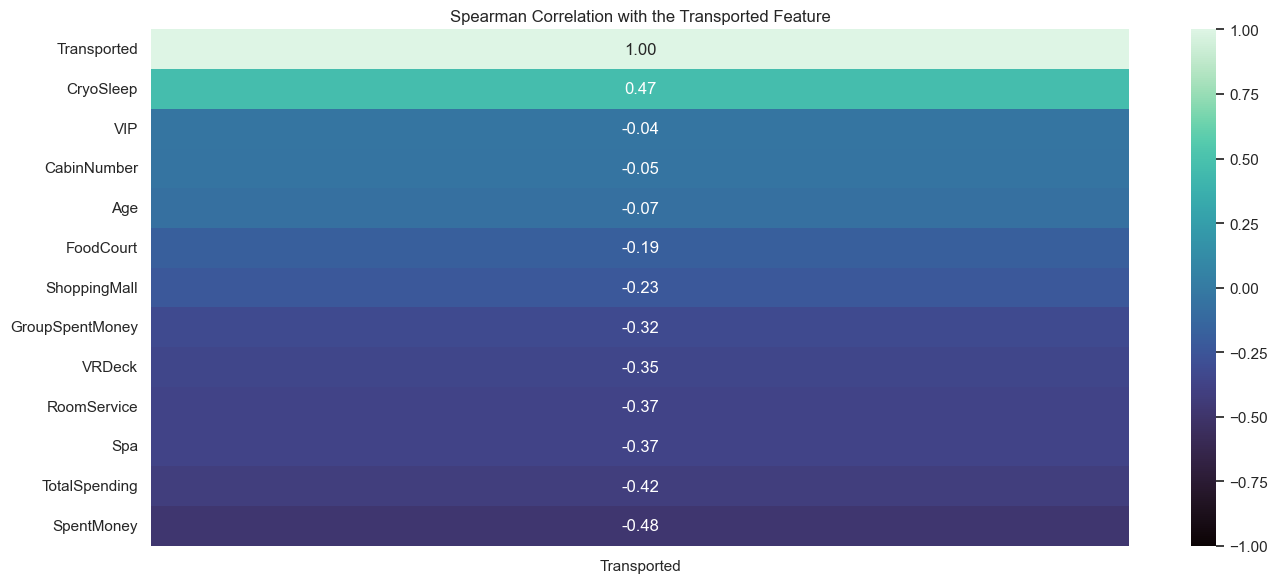

In [16]:
# Correlation
corr = data_train.select_dtypes(include=["float64", "int32", "int64"]).corr(method="spearman")["Transported"].sort_values(ascending=False)

# Plot
sns.heatmap(corr.to_frame(), vmin=-1, vmax=1, annot=True, fmt=".2f", cmap=palette_cmap)
plt.title('Spearman Correlation with the Transported Feature')
plt.tight_layout()
plt.show();

We see that Cryo Sleep have 0.47 correlation with target feature also Total Spending and Spent Money which we already described before have average negative correlation, as it not passing 0.5, we still use them, but if ML model show low performance we will consider to deal with them.

<b>Transported</b>

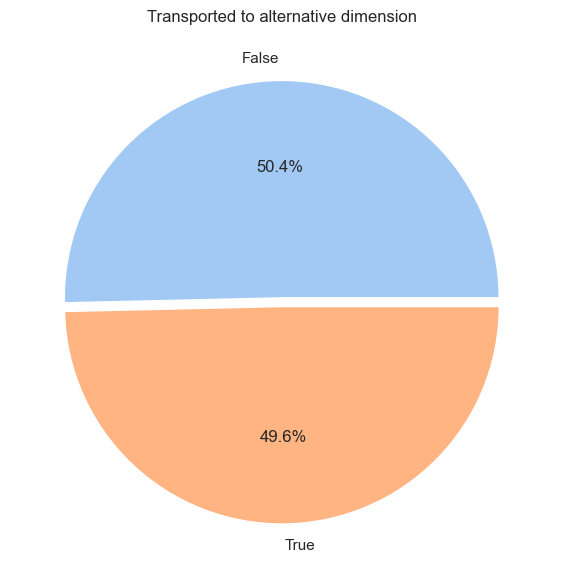

In [17]:
# Plot
plt.pie(
    x=data_train["Transported"].value_counts(), 
    labels=["False", "True"], 
    autopct="%1.1f%%", 
    explode=[0.02, 0.02])

plt.title("Transported to alternative dimension")
plt.tight_layout();

We can see that the target feature is balanced, almost half of people were transported while having only 0.8% of difference between groups it will be very good for ML model. 

Insight:
<li>It also gives use an idea that one side of the ship was effected more than others. It is possible that the ship didn't go through the space anomaly, but just one side of the ship touch it.</li>


<b>Name</b>

A lot of people can have same First Name, while having same Last Name indicates families. For this, we can check how many families we have in ship. Also need to inspect if last name can be only from one home planet.

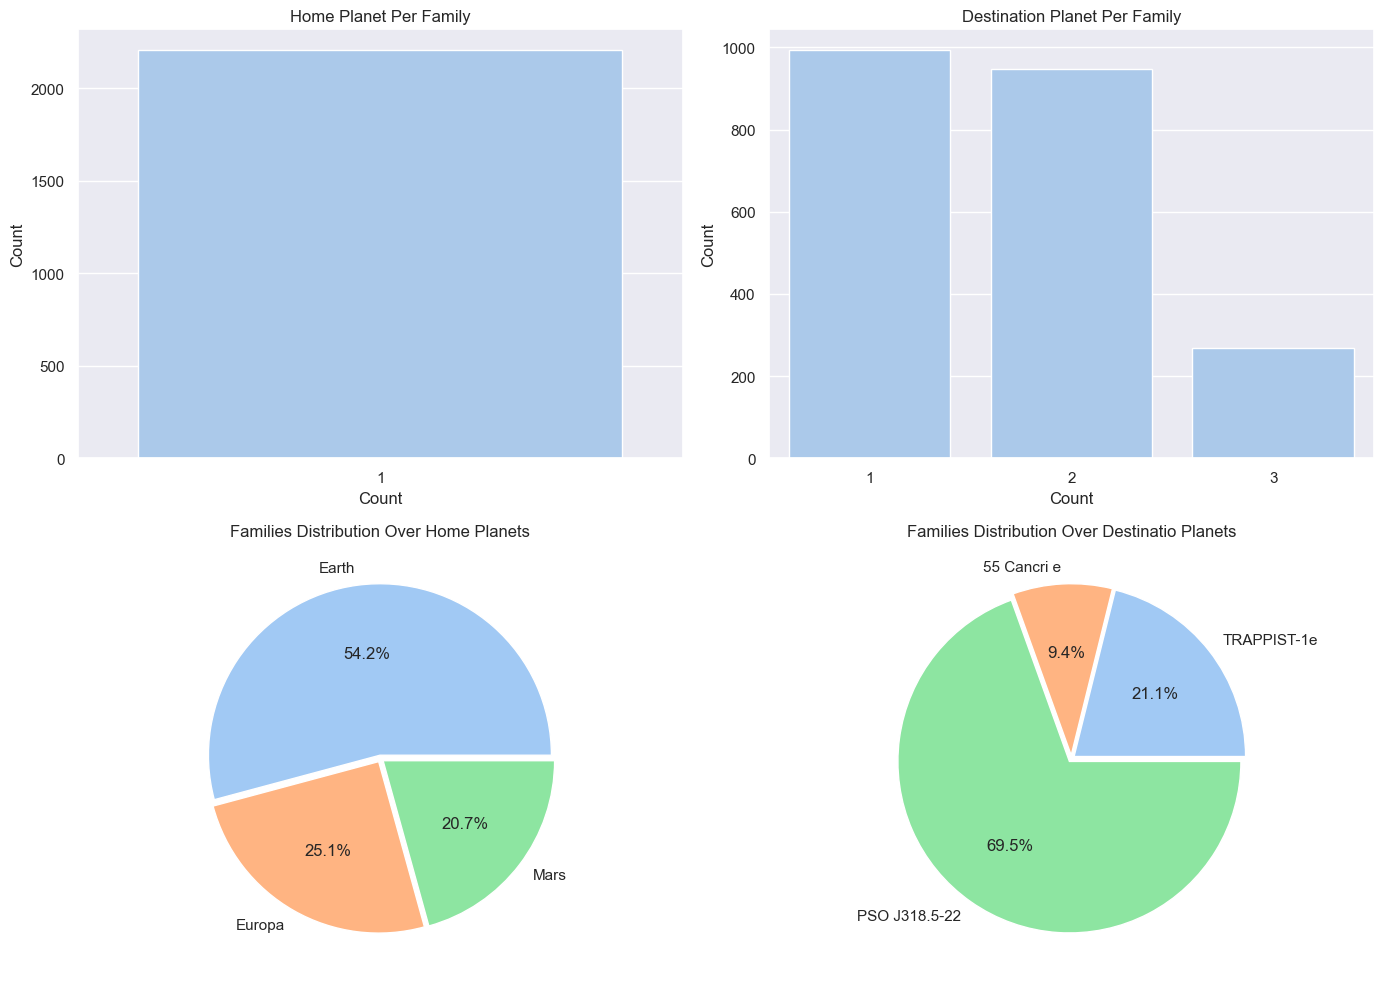

In [18]:
family_counts_hp = data_train.groupby(['HomePlanet', 'LastName']).size().reset_index(name='FamilyCount')
family_counts_by_hp = family_counts_hp.groupby('HomePlanet')['FamilyCount'].sum().reset_index()

unique_family_home_p = data_train.groupby(["LastName", "HomePlanet"])["HomePlanet"].size().unstack().count(axis=1)
unique_family_home_p = unique_family_home_p.reset_index(name="Count")

family_counts_ds = data_train.groupby(['Destination', 'LastName']).size().reset_index(name='FamilyCount')
family_counts_by_ds = family_counts_ds.groupby('Destination')['FamilyCount'].sum().reset_index()

unique_family_dest_p = data_train.groupby(["LastName", "Destination"])["Destination"].size().unstack().count(axis=1)
unique_family_dest_p = unique_family_dest_p.reset_index(name="Count")

# Plot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

sns.countplot(
    data=unique_family_home_p, 
    x="Count", 
    ax=axs[0])
axs[0].set_title("Home Planet Per Family")

sns.countplot(
    data=unique_family_dest_p,
    x="Count", 
    ax=axs[1])
axs[1].set_title("Destination Planet Per Family")

axs[2].pie(
    data=family_counts_by_hp, 
    x="FamilyCount", 
    labels=["Earth", "Europa", "Mars"], 
    autopct="%1.1f%%", 
    explode=[0.02, 0.02, 0.02])
axs[2].set_title("Families Distribution Over Home Planets")

axs[3].pie(
    data=family_counts_by_ds, 
    x="FamilyCount", 
    labels=["TRAPPIST-1e", "55 Cancri e", "PSO J318.5-22"], 
    autopct="%1.1f%%", 
    explode=[0.02, 0.02, 0.02])
axs[3].set_title("Families Distribution Over Destinatio Planets")

axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")

plt.tight_layout();

<li>Families with the same Last Name come from the same home planet.</li>
<li>54.2 % of ship population is from Earth.</li>
<li> 25.1% of people are from Europa and 20.8% from Mars.</li>

<li>Distribution of destination planet per family tell us that family travel to different planets.</li>
<li>69.5 % of ship population traveling to PSO J318.5-22.</li>
<li>21.1% of people traveling to TRAPPIST-1e and 9.4% to 55 Cancri.</li>

Insight:
<li>Fill Home Planet base by Last Name.</li>

Base by planet distance from Earth, it looks like spaceship travel in this chronological order (Data gathered from Wikipedia):
<ol>
    <li>Earth</li>
    <li>Mars - Distance to Earth: 54.6 million km</li>
    <li>Europa - Distance to Earth: 628.3 million km</li>
    <li>TRAPPIST-1e - Distance to Earth: 39.46 light years</li>
    <li>55 Cancri e - Distance to Earth: 40 light years</li>
    <li>PSO J318.5-22 - Distance to Earth: 80 light-years away</li>
</ol>

<b>RoomService, FoodCourt, ShoppingMall, Spa and VRDeck</b>

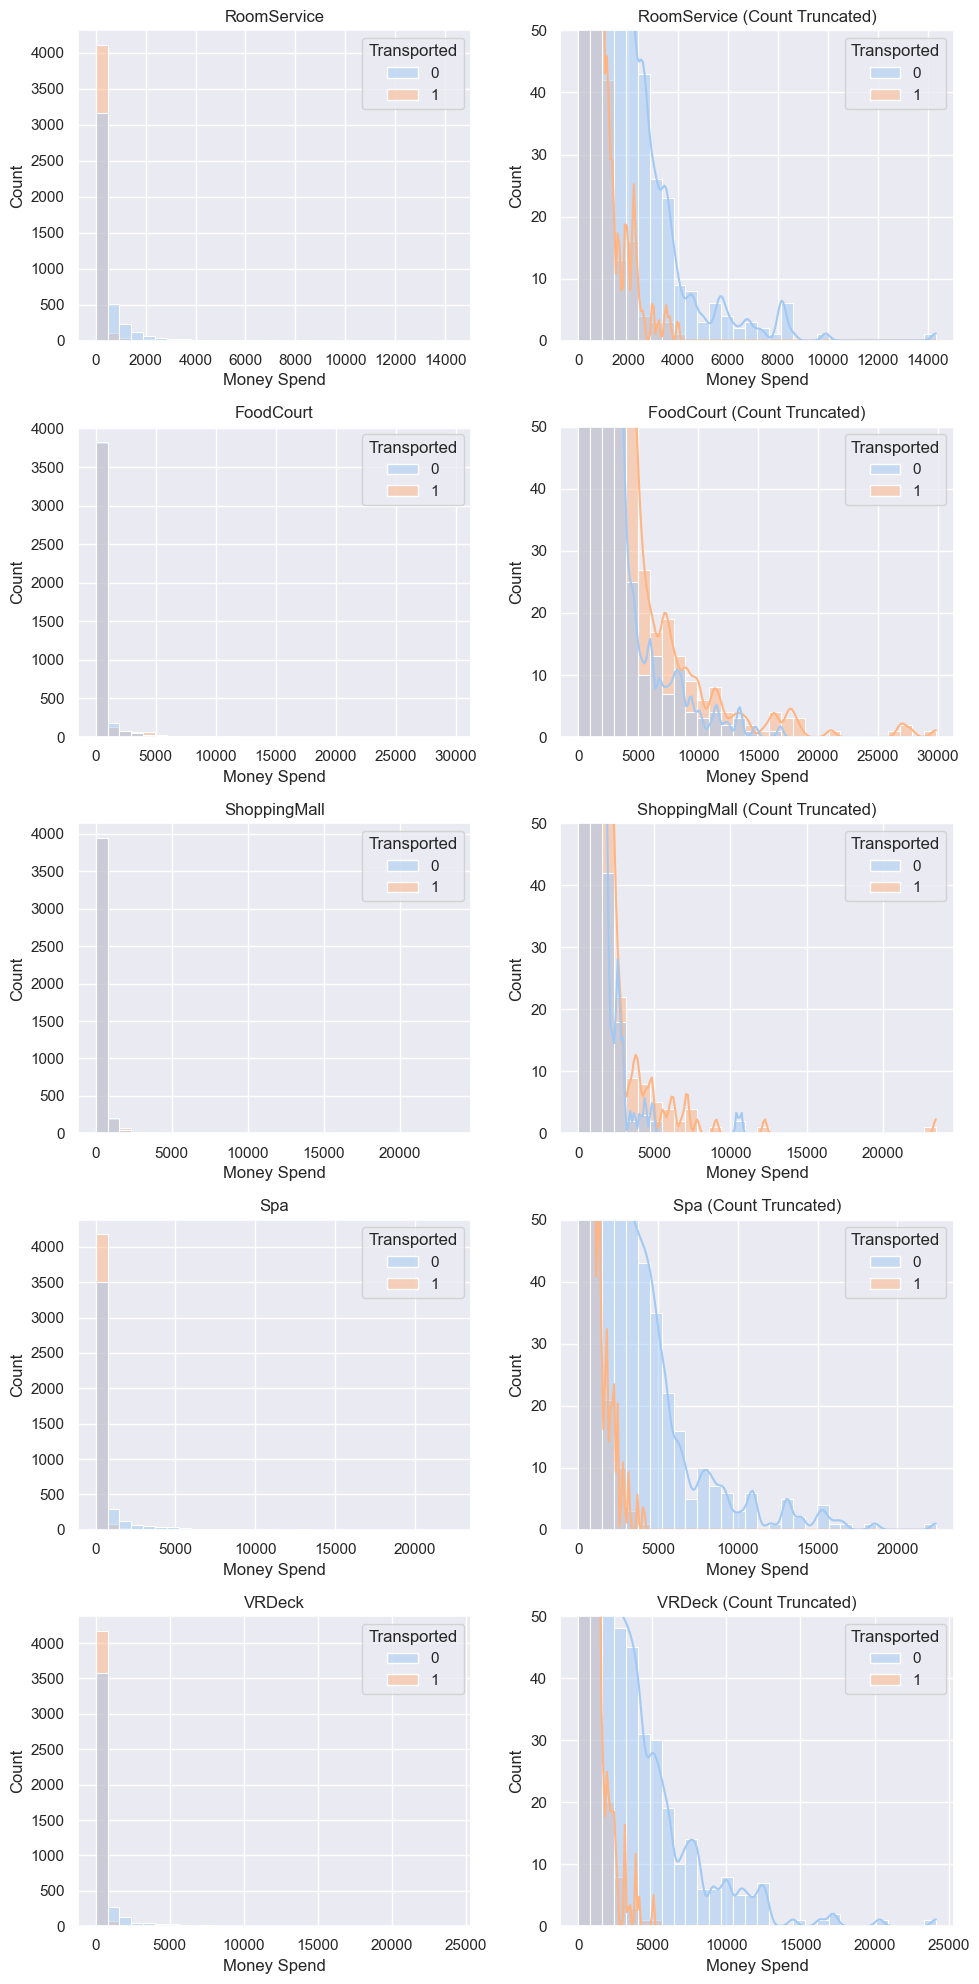

In [19]:
# Plot
fig=plt.figure(figsize=(10,20))
for i, feat_name in enumerate(features_spendings):
    ax = fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=data_train, x=feat_name, axes=ax, bins=30, kde=False, hue="Transported")
    ax.set_xlabel("Money Spend")
    ax.set_title(feat_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=data_train, x=feat_name, axes=ax, bins=30, kde=True, hue="Transported")
    plt.ylim([0,50])
    ax.set_xlabel("Money Spend")
    ax.set_title(f"{feat_name} (Count Truncated)")
    
fig.tight_layout()
plt.show() 

<li>Most of the people in spaceship spend 0 while traveling.</li>
<li>We have long tails to the right, there are people in the dataset who spend more than 10 000 or 20 000 while traveling, it indicates some outliers in our dataset.</li>
<li>Looks like people who were effected by anomaly spent less money than others.</li>

Insight:

<li>Create a feature which indicates if people spend money or not (0 or 1).</li>
<li>Create a feature which indicates how much it spent overall.</li>
<li>Deal with extreme outliers if ML model performs poor.</li>

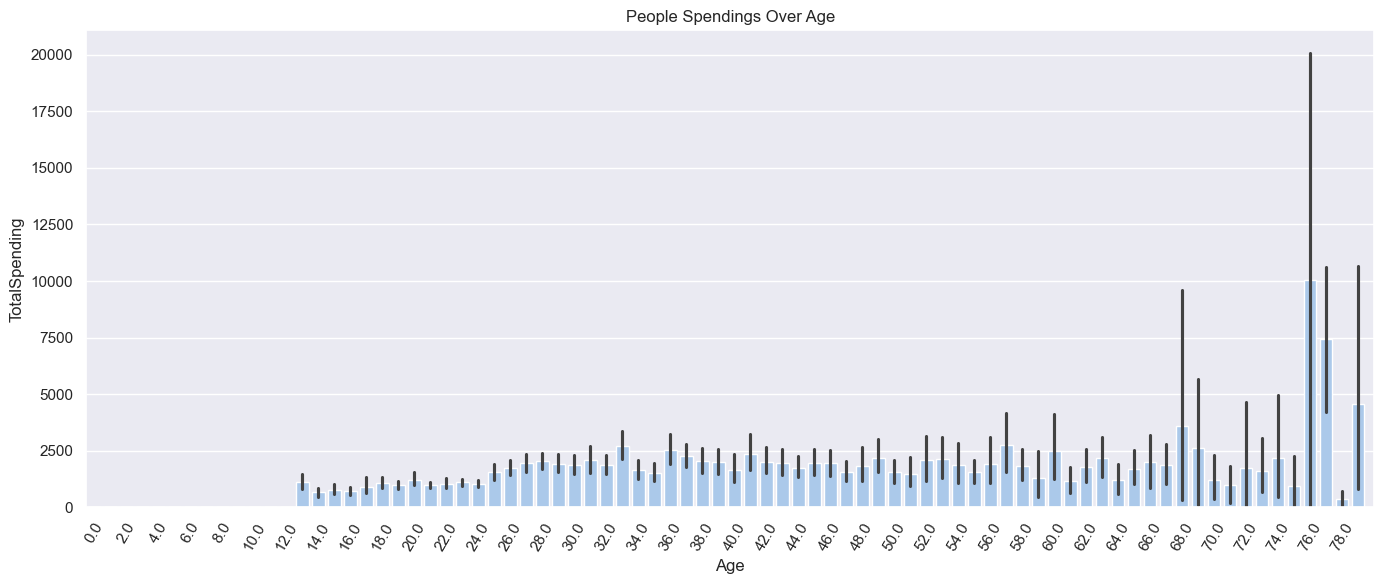

In [20]:
# Plot
sns.barplot(data=data_train, x="Age", y="TotalSpending")

plt.xticks(ticks=range(0, 81, 2), rotation=60)
plt.title("People Spendings Over Age")
plt.tight_layout();

<li>People from 0 to 12 years old didn't spend money at all.</li>
<li>Most of the outliers appears with older people.</li>

Insight:

<li>Filling missing values of people younger than 13 with 0.</li>
<li>Older people, missing values can be filled with average of row.</li>

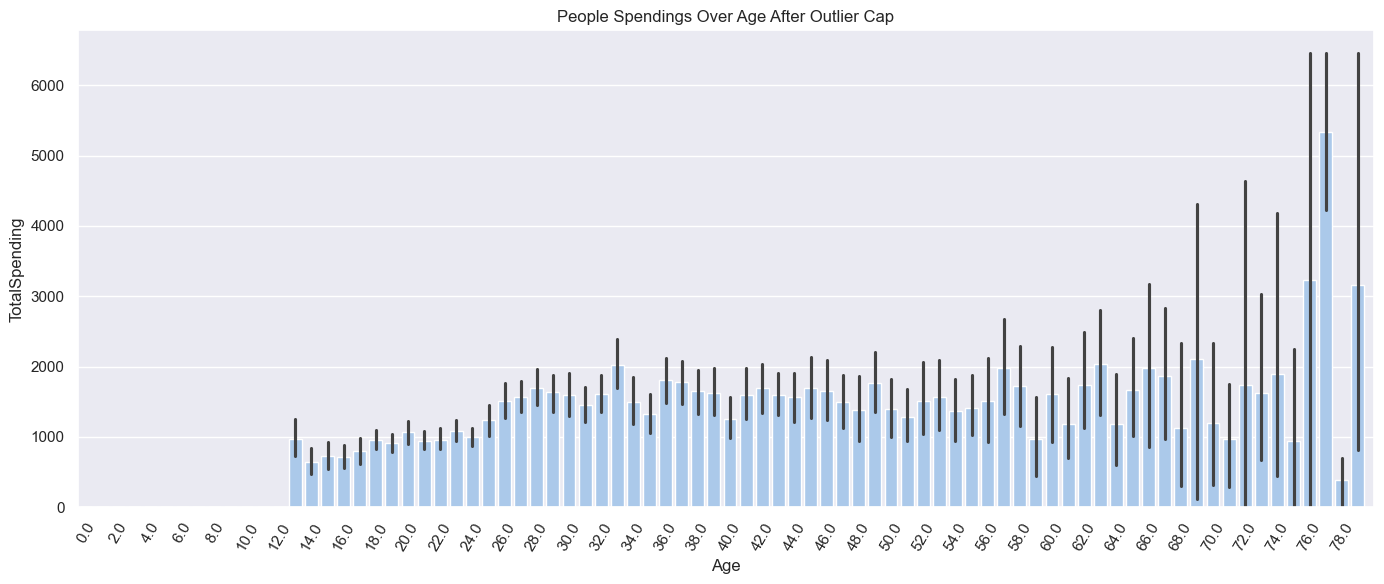

In [21]:
# Cap the extreme values to a specified percentile.
cap = data_train["TotalSpending"].quantile(0.95)
cap_test = data_test["TotalSpending"].quantile(0.95)
data_train["TotalSpending"] = np.where(data_train["TotalSpending"] > cap, cap, data_train["TotalSpending"])
data_test["TotalSpending"] = np.where(data_test["TotalSpending"] > cap_test, cap_test, data_test["TotalSpending"])

# Plot
sns.barplot(data=data_train, x="Age", y="TotalSpending")

plt.xticks(ticks=range(0, 81, 2), rotation=60)
plt.title("People Spendings Over Age After Outlier Cap")
plt.tight_layout();

We cap Total Spending feature to be maximum at 0.95 quantile.
We lower spendings more than triple, from 20 000 to 6 400, we still see outliers and big distribution over old age people, but situation is better.

<b>VIP</b>

Let's check if all VIP stay in same group and how much money spend VIP and not VIP.

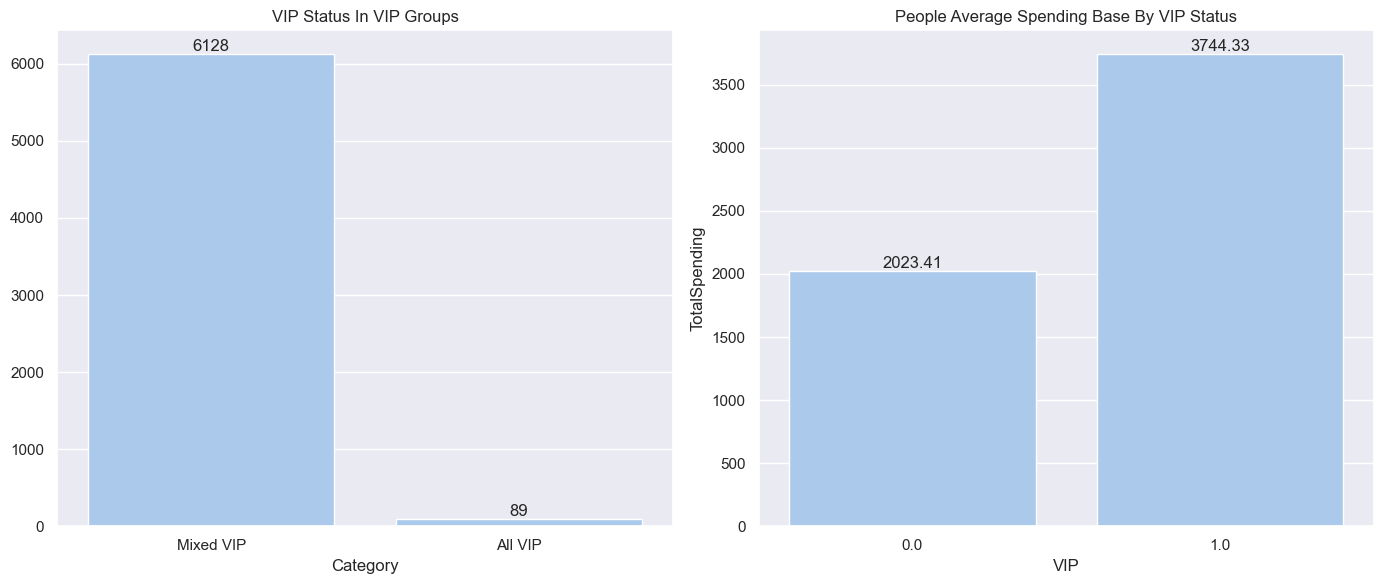

In [22]:
grouped_vip = data_train.groupby("GroupId")["VIP"]
all_vip = grouped_vip.agg(lambda x: (x == 1).all()).reset_index()
all_vip["Category"] = all_vip["VIP"].apply(lambda x: "All VIP" if x else "Mixed VIP")
category_counts = all_vip["Category"].value_counts()

vip_spendings = data_train[data_train["SpentMoney"] != 0].groupby(["VIP"])["TotalSpending"].mean().reset_index()
vip_spend_avg = vip_spendings["TotalSpending"].values[1]
not_vip_spend_avg = vip_spendings["TotalSpending"].values[0]
threshold = round((vip_spend_avg + not_vip_spend_avg)/2, 2)

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax1)
sns.barplot(data=vip_spendings, x="VIP", y="TotalSpending", ax=ax2)

for container in ax1.containers:
    ax1.bar_label(container)

for container in ax2.containers:
    ax2.bar_label(container)

ax1.set_title("VIP Status In VIP Groups")
ax2.set_title("People Average Spending Base By VIP Status")
plt.tight_layout();

In [23]:
f"We can see that people who spend less than {threshold} can be considered to be not VIP, and if spent more - VIP."

'We can see that people who spend less than 2883.87 can be considered to be not VIP, and if spent more - VIP.'

<li>We can see that only 89 groups have all VIP members in group. While 6128 groups have mixed VIP status.</li>

Insights:
<li>Missing values of VIP status can be filled base by threshold of money spent, but we need to consider that as we don't have a lot of VIP in ship.</li>

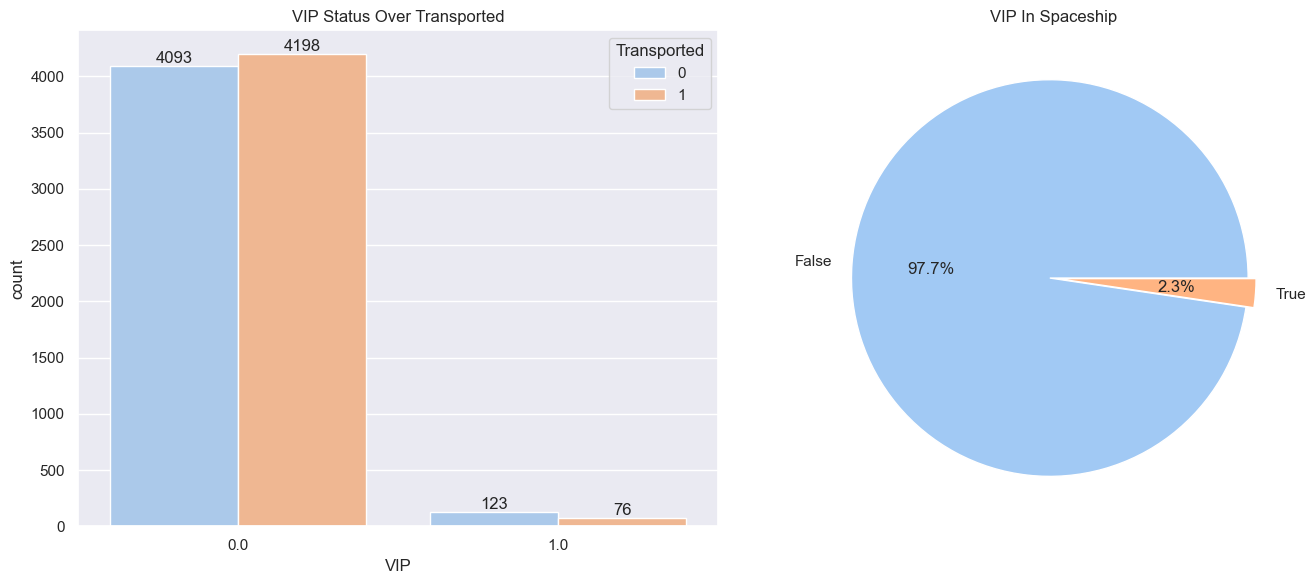

In [24]:
# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Count plot
sns.countplot(data=data_train, x="VIP", hue="Transported", ax=ax1)

for container in ax1.containers:
    ax1.bar_label(container)

# % of VIP Pie plot
ax2.pie(
    x=data_train["VIP"].value_counts(), 
    labels=["False", "True"], 
    autopct="%1.1f%%", 
    explode=[0.02, 0.02])

ax1.set_title("VIP Status Over Transported")

plt.title("VIP In Spaceship")
plt.tight_layout();

<li>Being VIP or not have similar chances to be transported.</li>
<li>VIP only takes 2.3% of training dataset.</li>
<li>97.7% of people are not VIP in training data.</li>

Insights:
<li>We can consider removing VIP feature as we have only 2.3% of VIP also, some of VIP have missing values, which would make harder to use this feature.</li>


<b>Age</b>

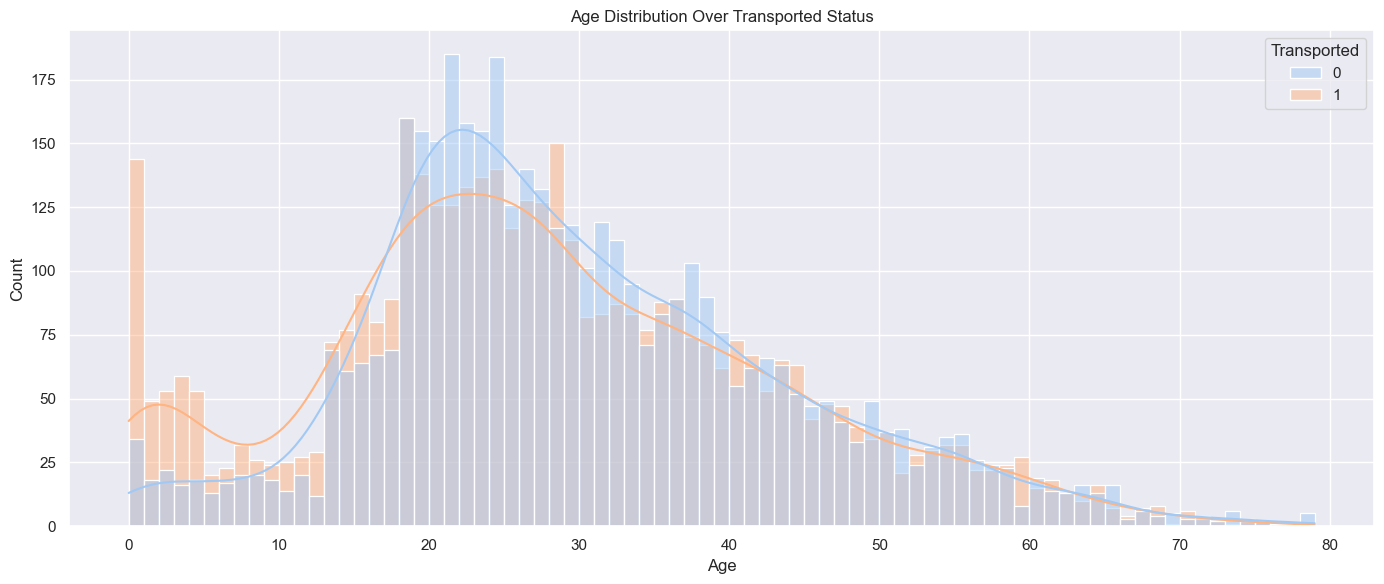

In [25]:
# Plot
sns.histplot(data=data_train, x="Age", hue="Transported", bins=79, kde=True)
plt.title("Age Distribution Over Transported Status")
plt.tight_layout();

<li>The distribution is skewed to the right, it is indicating that a longer tail on the right side.</li>
<li>We have some older people in the dataset, but most of it are younger.</li>
<li>Base on overlapping distribution, it looks like younger people get transported more than older.</li>
<li>Biggest spike is from 20 to 30 years old people, not only most of the people in dataset, but also most of transported people.</li>
<li>From about 40, chances to be transported are almost equal.</li>

Insights:
<li>Missing values will be filled with median of people combining with other features: home planet, destination, money spent, deck and if traveling alone.</li>
<li>We can create additional bins for age ranges.</li>
<li>Age from 0 - 13, 14 - 18, 19 - 25, 26 - 30, 31 - 40, 41 - 50, 51 - 79.</li>

<b>Destination and HomePlanet</b>

In [26]:
d_counts = data_train.groupby(["Destination", "Transported"]).size().reset_index(name="Count")
h_counts = data_train.groupby(["HomePlanet", "Transported"]).size().reset_index(name="Count")

d_total_count = d_counts.groupby(["Destination"])["Count"].sum().reset_index()
d_total_count = d_total_count.rename(columns={"Count": "TotalCount"})
d_counts = d_counts.merge(d_total_count, on="Destination")
d_counts["Percentage"] = round((d_counts["Count"] / d_counts["TotalCount"]) * 100, 2)
d_counts = d_counts.drop(columns=["TotalCount"])

h_total_count = h_counts.groupby(["HomePlanet"])["Count"].sum().reset_index()
h_total_count = h_total_count.rename(columns={"Count": "TotalCount"})
h_counts = h_counts.merge(h_total_count, on="HomePlanet")
h_counts["Percentage"] = round((h_counts["Count"] / h_counts["TotalCount"]) * 100, 2)
h_counts = h_counts.drop(columns=["TotalCount"])

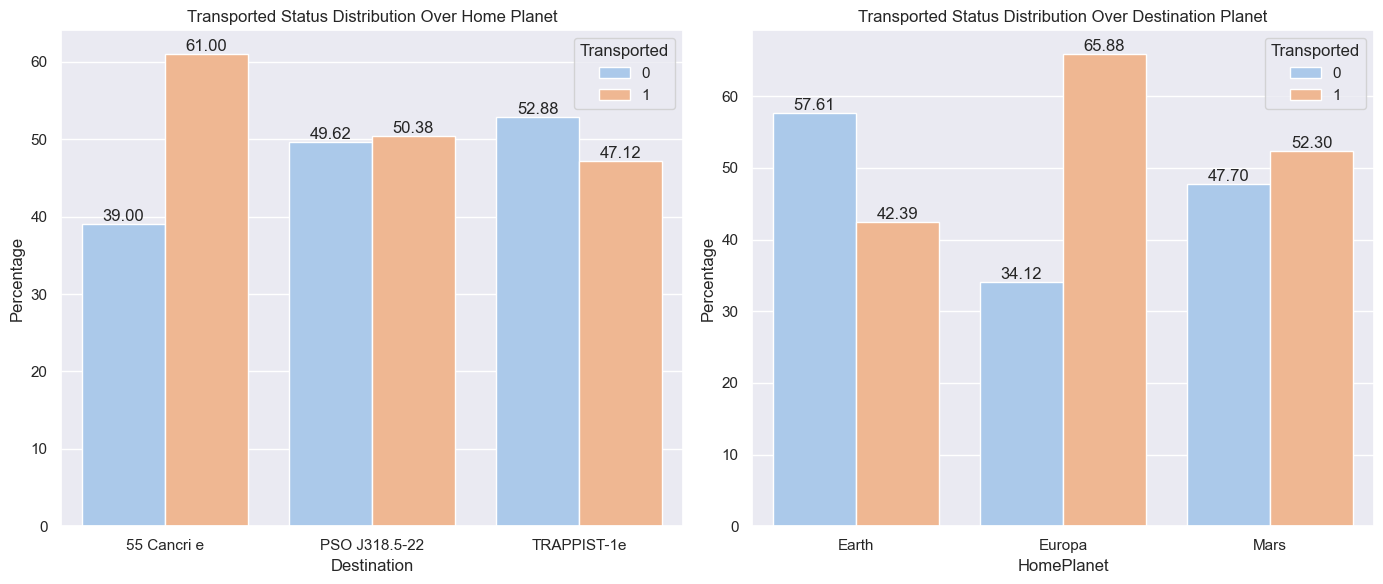

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.barplot(data=d_counts, x="Destination", y="Percentage", hue="Transported", ax=ax1)
sns.barplot(data=h_counts, x="HomePlanet", y="Percentage", hue="Transported", ax=ax2)

for container in ax1.containers:
    ax1.bar_label(container, fmt="%.2f")
        
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f")

ax1.set_title("Transported Status Distribution Over Home Planet")
ax2.set_title("Transported Status Distribution Over Destination Planet")
plt.tight_layout();

<li>People going from Earth have the biggest chance to not be transported.</li>
<li>Travelers from Europe have almost double chance to be transported than not transported. </li>
<li>Travelers from Mars have similar chances to be or not to be transported.</li>
<li>PSO J318.5-22 have almost equal chances to get transported than not</li>
<li>55 Cancri e have higher chance to be transported.</li>
<li>TRAPPIST-1e have higher chance to not be transported.</li>

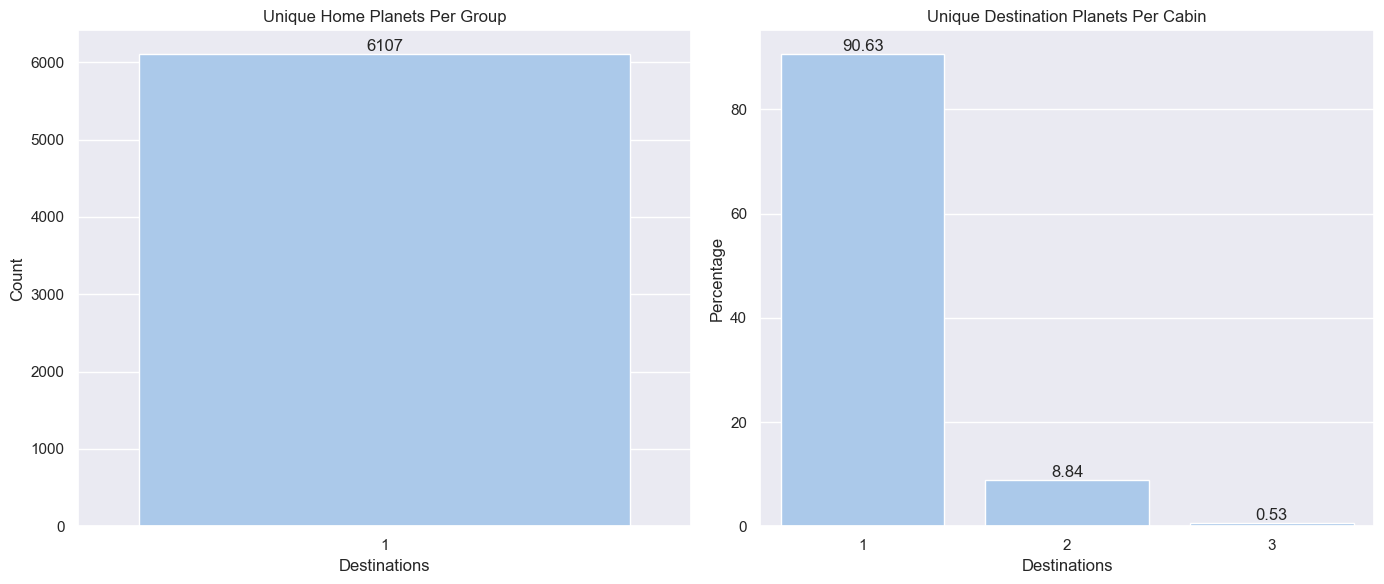

In [28]:
group_hp_count = data_train.groupby(["GroupId","HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
group_hp_count = (group_hp_count>0).sum(axis=1).value_counts()

group_d_count = data_train.groupby(["Deck","CabinNumber", "Side", "Destination"])["Destination"].size().unstack().fillna(0)
group_d_count = (group_d_count>0).sum(axis=1).value_counts()
group_d_count = group_d_count.reset_index() #.drop(columns=["index"])
group_d_count["Percentage"] = round((group_d_count["count"] / group_d_count["count"].sum()) * 100, 2)

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(data=group_hp_count, ax=ax1)
sns.barplot(data=group_d_count, x="index", y="Percentage", ax=ax2)

for container in ax1.containers:
    ax1.bar_label(container)

for container in ax2.containers:
    ax2.bar_label(container)

ax1.set_title("Unique Home Planets Per Group")
ax2.set_title("Unique Destination Planets Per Cabin")
ax1.set_ylabel("Count")
ax2.set_ylabel("Percentage")
ax1.set_xlabel("Destinations")
ax2.set_xlabel("Destinations")
plt.tight_layout();

<li>All groups have only one unique Home planet.</li>
<li>90.63% of the cabins have only one destination.</li>
<li>8.84% chance that group's have 2 destinations ant 0.53% that it will have 3 destinations</li>

Insights:
<li>Home Planet missing values can be filled base by group with 100% confidence.</li>
<li>Filling the Destination planet with the mode of the group.</li>

<b>Cabin</b>

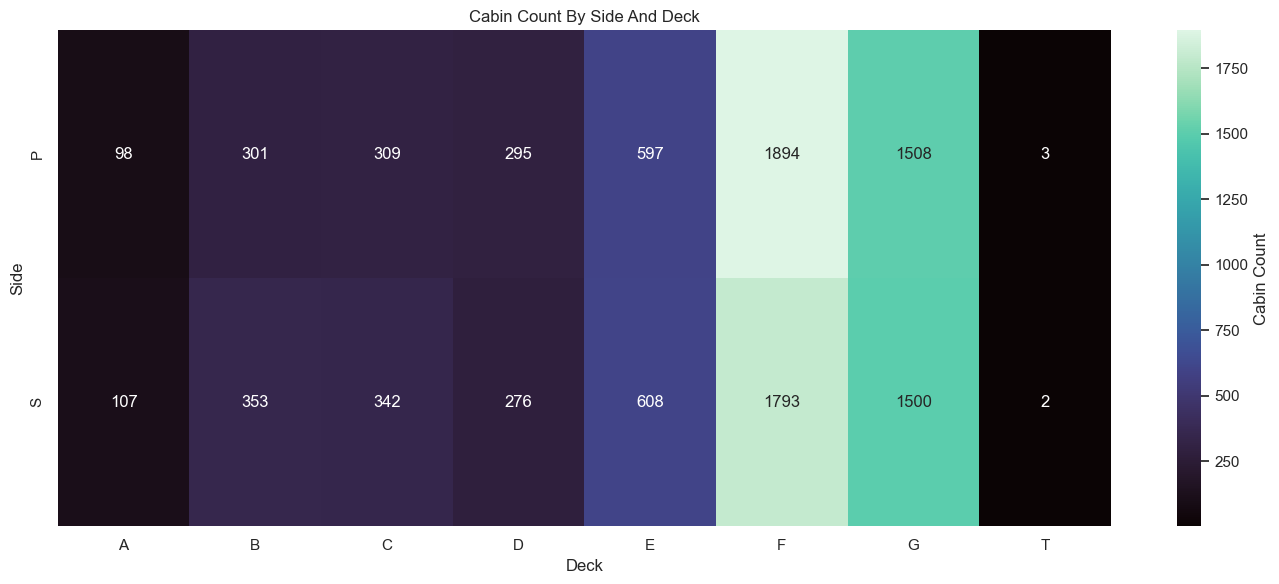

In [29]:
# Group by side and deck and cabin number
cabin_counts = data_train.groupby(["Side", "Deck"])["CabinNumber"].max().unstack()

# Create a heatmap
sns.heatmap(cabin_counts, annot=True, cmap=palette_cmap, fmt="g", cbar_kws={"label": "Cabin Count"})
plt.title("Cabin Count By Side And Deck")
plt.tight_layout();

<ol>
<li>Decks A and T are the smallest one, indicating front or end.</li>
<li>Decks B, C and D are average ones.</li>
<li>Deck E, F and G are the largest ones, holding most cabins in the ship.</li>
</ol>

<ol>
<li>Biggest deck of the ship is F, holding almost 1900 cabins per side.</li>
<li>Deck T show extreme outlier, which can indicate ship end or front.</li>
<li>Deck A is the smallest in the ship, holding the least people</li>
<li>Decks B and C have up to 353 cabins per deck on one side.</li>
<li>Deck D have up to 295 cabins per deck on one side.</li>
<li>Decks E, F and G are larger ones. E deck holds up to 608 cabins. F holds up to 1894 cabins and G holds up to 1508 cabins.</li>
</ol>

As we know how many cabins are per deck, we can check the mean of money spent per deck on average for people who are not in cryosleep.

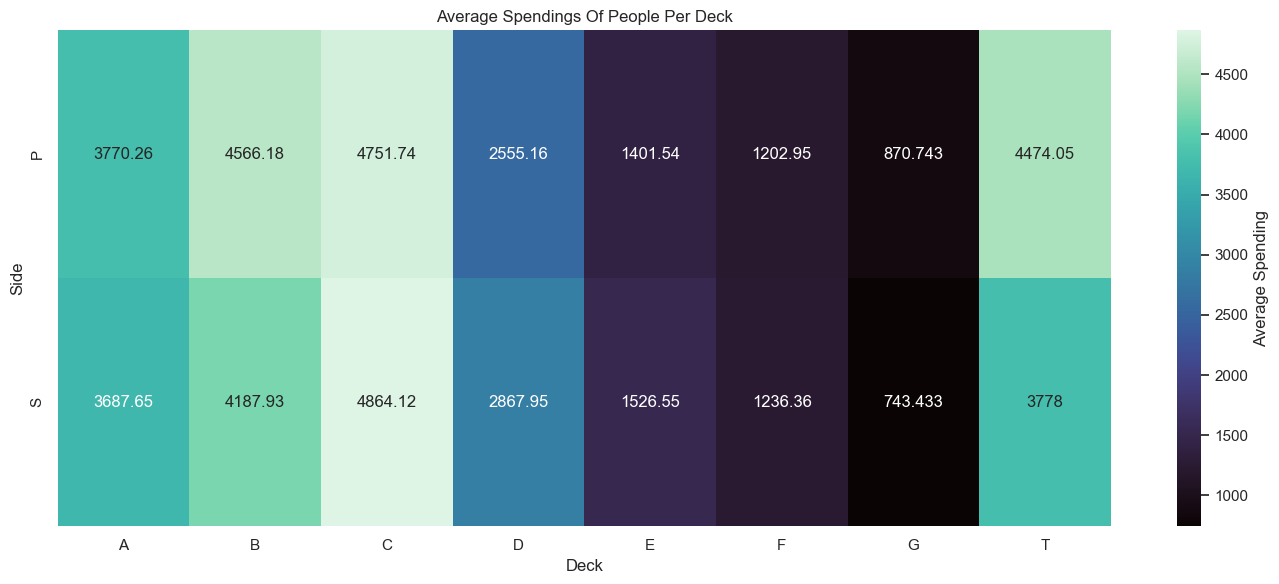

In [30]:
# Group by side and deck and cabin number
spendings_per_deck = data_train[data_train["CryoSleep"] != 1].groupby(["Side", "Deck"])["TotalSpending"].mean().unstack()
spendings_per_deck_test = data_test[data_test["CryoSleep"] != 1].groupby(["Side", "Deck"])["TotalSpending"].mean().unstack()

# Create a heatmap
sns.heatmap(spendings_per_deck, annot=True, cmap=palette_cmap, fmt="g", cbar_kws={"label": "Average Spending"})
plt.title("Average Spendings Of People Per Deck")
plt.tight_layout();

<li>Decks A, B, C and T are showing higher spending decks than E, F and G.</li>
<li>While D Can be place above average.</li>

Insights:
<li>We can will missing values by checking person Total Spending with deck Median.</li>

In [31]:
left_deck_home = data_train.where(data_train["Side"] == "P")
left_deck_home = left_deck_home.groupby(["Deck", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)

right_deck_home = data_train.where(data_train["Side"] == "S")
right_deck_home = right_deck_home.groupby(["Deck", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)

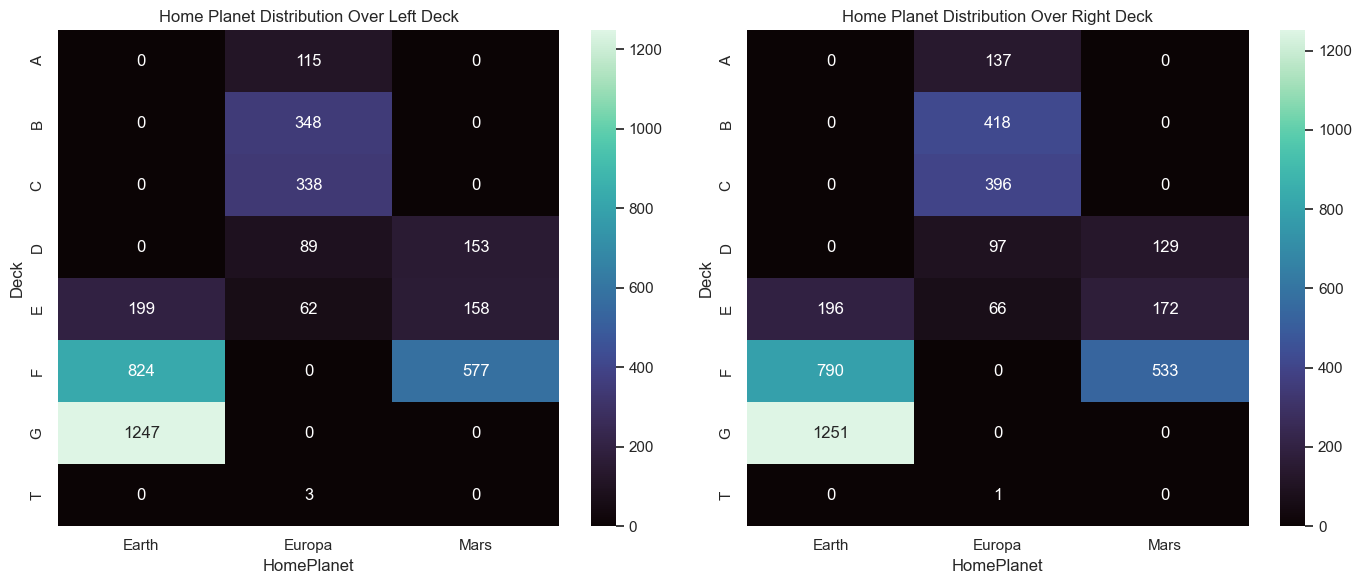

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.heatmap(left_deck_home, annot=True, cmap=palette_cmap, fmt="g", ax=ax1)
sns.heatmap(right_deck_home, annot=True, cmap=palette_cmap, fmt="g", ax=ax2)

ax1.set_title("Home Planet Distribution Over Left Deck")
ax2.set_title("Home Planet Distribution Over Right Deck")
plt.tight_layout();

<li>Distribution over both decks are similar.</li>
<li>People from Europe stay in decks A, B, C, E, E. Most of them stay at decks A, B and C. We can see outliers in T deck.</li>
<li>People from Mars stay in decks D, E, F. Most of them in F.</li>
<li>People from Earth stay in decks E, F, G. Most of them in F and G.</li>

Insights:
<li>Base on distribution over decks we can will missing values for Home Planet.</li>

In [33]:
left_deck_dest = data_train.where(data_train["Side"] == "P")
left_deck_dest = left_deck_dest.groupby(["Deck", "Destination"])["Destination"].size().unstack().fillna(0)

right_deck_dest = data_train.where(data_train["Side"] == "S")
right_deck_dest = right_deck_dest.groupby(["Deck", "Destination"])["Destination"].size().unstack().fillna(0)

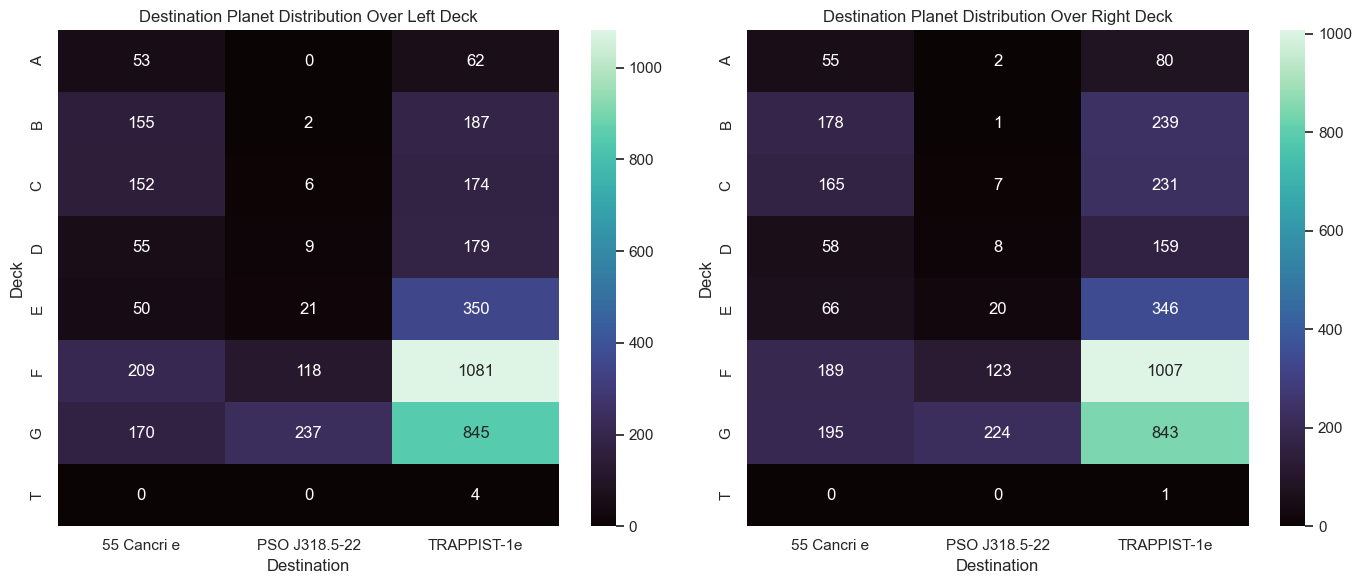

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(left_deck_dest, annot=True, cmap=palette_cmap, fmt="g", ax=ax1)
sns.heatmap(right_deck_dest, annot=True, cmap=palette_cmap, fmt="g", ax=ax2)

ax1.set_title("Destination Planet Distribution Over Left Deck")
ax2.set_title("Destination Planet Distribution Over Right Deck")
plt.tight_layout();

<li>Distribution over both decks are similar.</li>
<li>People going to 55 Concri e stay at all decks except T. Most of them B, C and F, G</li>
<li>People going to PSO J318.5-22 mostly stay at F ang G decks, while we have some outliers in B - E decks.</li>
<li>People going to TRAPPIST-1e mostly stay at F ang G decks, while we have long tail going from F to A.</li>

Insights:
<li>Split Cabin feature into 3 separate ones: Deck, Cabin Number and Side.</li>
<li>Deck T show big outliers, which can be considered to be dropped later.</li>

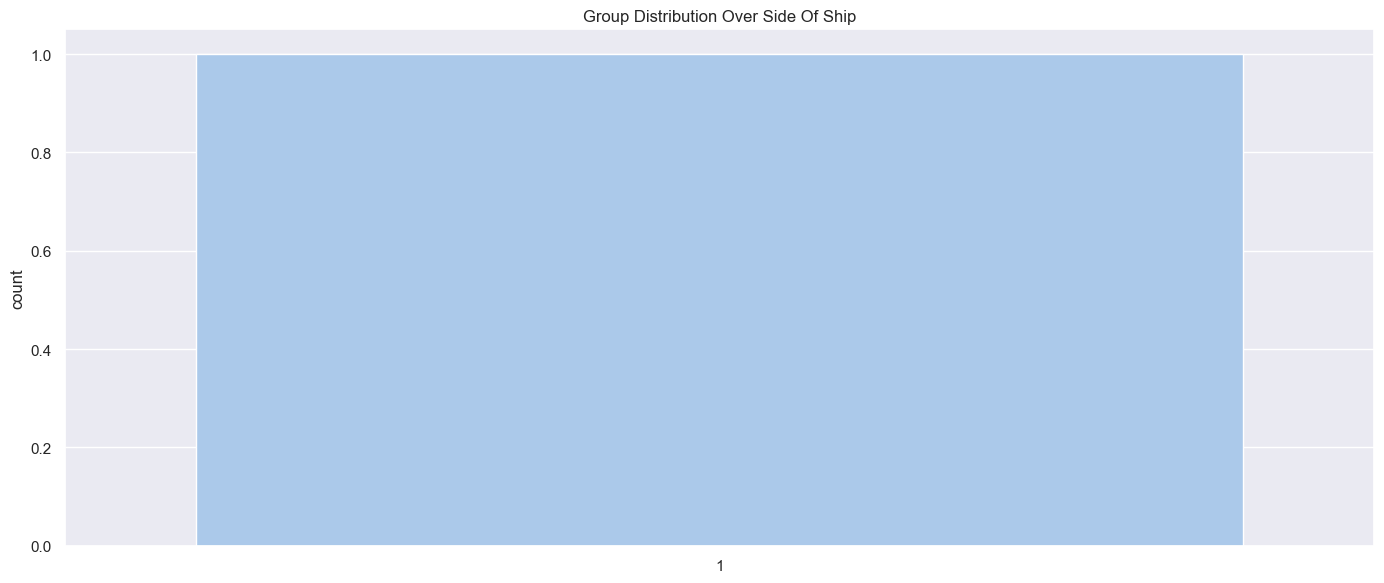

In [35]:
side_groupid = data_train.groupby(["GroupId","Side"])["Side"].size().unstack().fillna(0)
side_groupid_n_zero = (side_groupid>0).sum(axis=1).value_counts()

sns.countplot(data=side_groupid_n_zero)
plt.title("Group Distribution Over Side Of Ship")
plt.tight_layout();

All people in groups stay in one side of the ship.

Insights:
<li>Fill missing values of Side.</li>

Let's check if all group members in the cabin have same Destination planet.

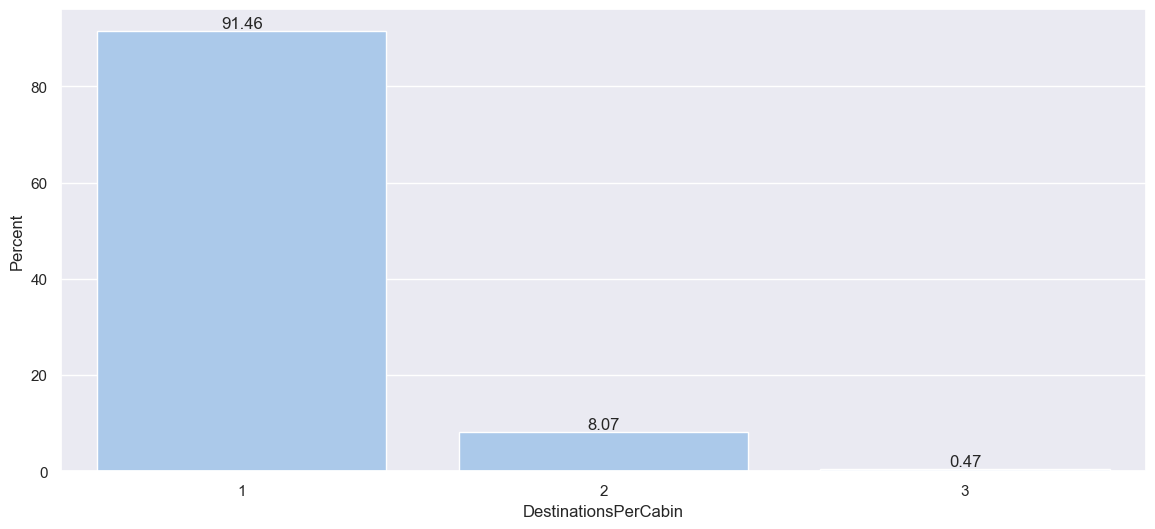

In [36]:
# Data preprocesing
data_train_des_per_c = data_train.dropna()
dst_per_cabin = data_train_des_per_c.groupby(["Deck","CabinNumber","Side"])["Destination"].nunique().reset_index(name="DestinationsPerCabin")
dst_per_cabin = dst_per_cabin["DestinationsPerCabin"].value_counts().reset_index(name="Count")
dst_per_cabin["Percent"] = round(((dst_per_cabin["Count"] /  dst_per_cabin["Count"].sum()) * 100), 2)

# Plot
ax = sns.barplot(data=dst_per_cabin, x="DestinationsPerCabin", y="Percent")

for container in ax.containers:
    ax.bar_label(container)


<li>About ~91% of the cabins have only one destination planet.</li>
<li>About ~8% have 2 destinations per cabin.</li>
<li>Less than 1% of the times cabin have 3 destination planets.</li>

Insights:
<li>Fill missing destinations by cabin mode of destination. We will consider dropping this approach if the model performs bad.</li>

Observe how group id correlates with cabin number. 

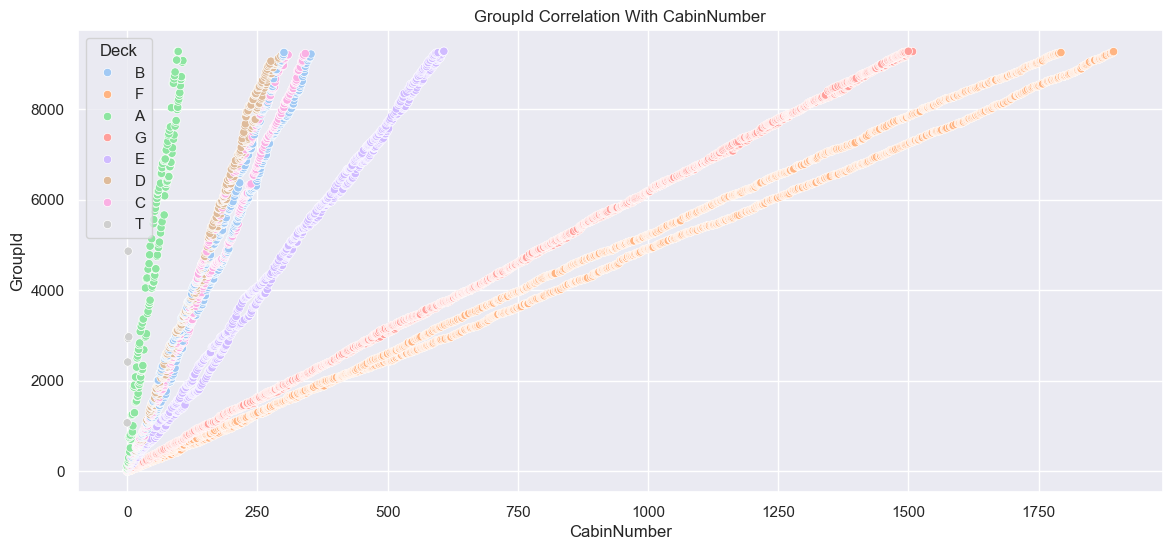

In [37]:
sns.scatterplot(
    data=data_train, 
    x="CabinNumber", 
    y=data_train["GroupId"].astype(int), 
    hue="Deck")

plt.title("GroupId Correlation With CabinNumber");

<li>We have strong linear relationship between Group Id and Cabin Number.</li>

Insights:
<li>Fill missing values using linear regression model.</li>


<b>CryoSleep</b>

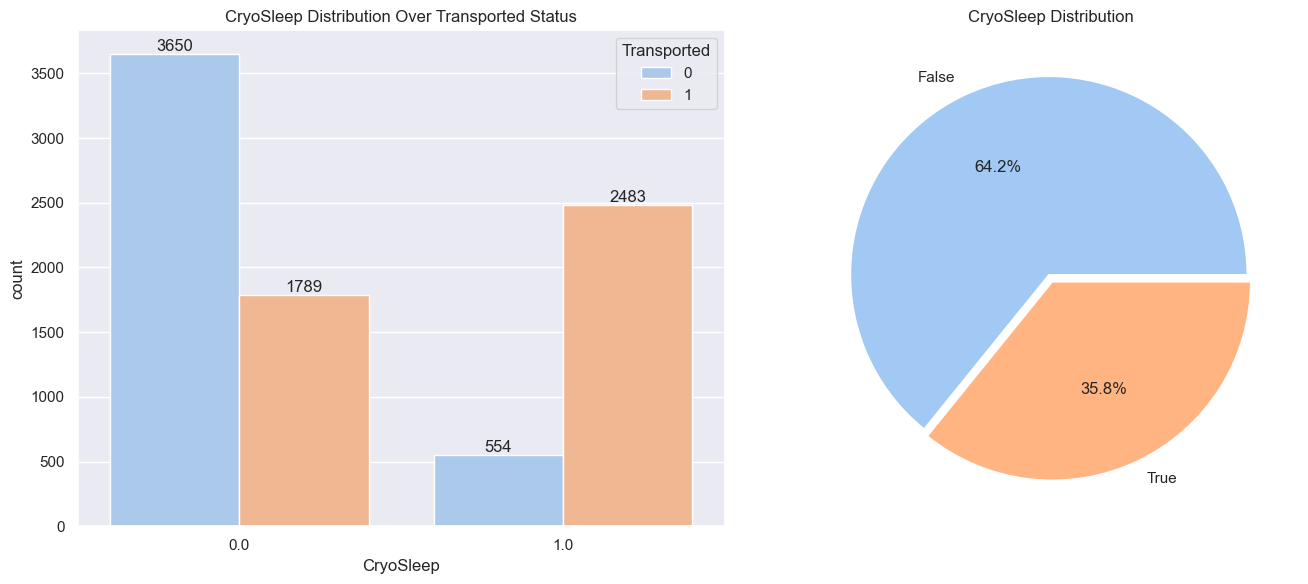

In [38]:
# Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Count plot
sns.countplot(data=data_train, x="CryoSleep", hue="Transported", ax=ax1)

for container in ax1.containers:
    ax1.bar_label(container)

# % of VIP Pie plot
ax2.pie(
    x=data_train["CryoSleep"].value_counts(), 
    labels=["False", "True"], 
    autopct="%1.1f%%", 
    explode=[0.02, 0.02])

ax1.set_title("CryoSleep Distribution Over Transported Status")
ax2.set_title("CryoSleep Distribution")
plt.tight_layout();

<li>35.8% of people in ship are in cryosleep.</li>
<li>64.2% are awake.</li>
<li>People who were in cryosleep have 5 times bigger chance to be transported.</li>
<li>People who were not in cryosleep have 2 times less chance to be transported.</li>

Insights:
<li>We can assume that people in cryosleep stay in one place over all travel.</li>
<li>They shouldn't spend any money.</li>

<b>Anomaly Hypothesis Testing</b>

As we discussed before, it is possible that ship touch anomaly by the side of ship, let's test this Hypothesis.

<li>People traveling in spaceship.</li>
<li>Significance level: α = 0.05</li>
<li>Null: People from both sides of the ship are likely to be transported.</li>
<li>Alternative: One or other side of the ship have higher chance to get people transported.</li>

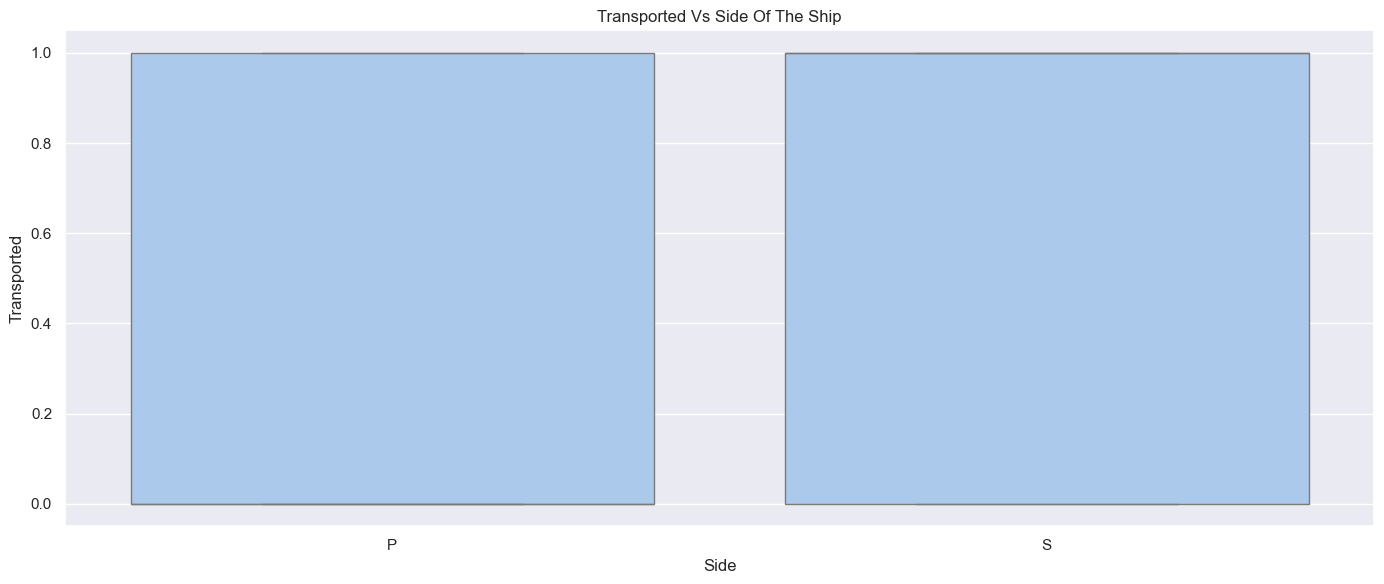


Chi-Square Statistic: 91.0595970786772
P-value: 1.3940936254458288e-21
Degrees of Freedom: 1
Expected Frequencies Table:
[[2087.64963504 2118.35036496]
 [2128.35036496 2159.64963504]]


Reject the null hypothesis: There is a significant association between space ship side and transported status.


In [39]:
# Plot
sns.boxplot(data=data_train, x="Side", y="Transported")
plt.title("Transported Vs Side Of The Ship")
plt.tight_layout()
plt.show()


contingency_table = pd.crosstab(data_train["Side"], data_train["Transported"])
# Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Results
print("\nChi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)
print("\n")

# Hypothesis
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant association between space ship side and transported status.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between space ship side and transported status.")

<li>Chi-Squere show strong association between values.</li>
<li>P-value is very small, so the likelihood of being transported differs significantly based on the side of the ship.</li>

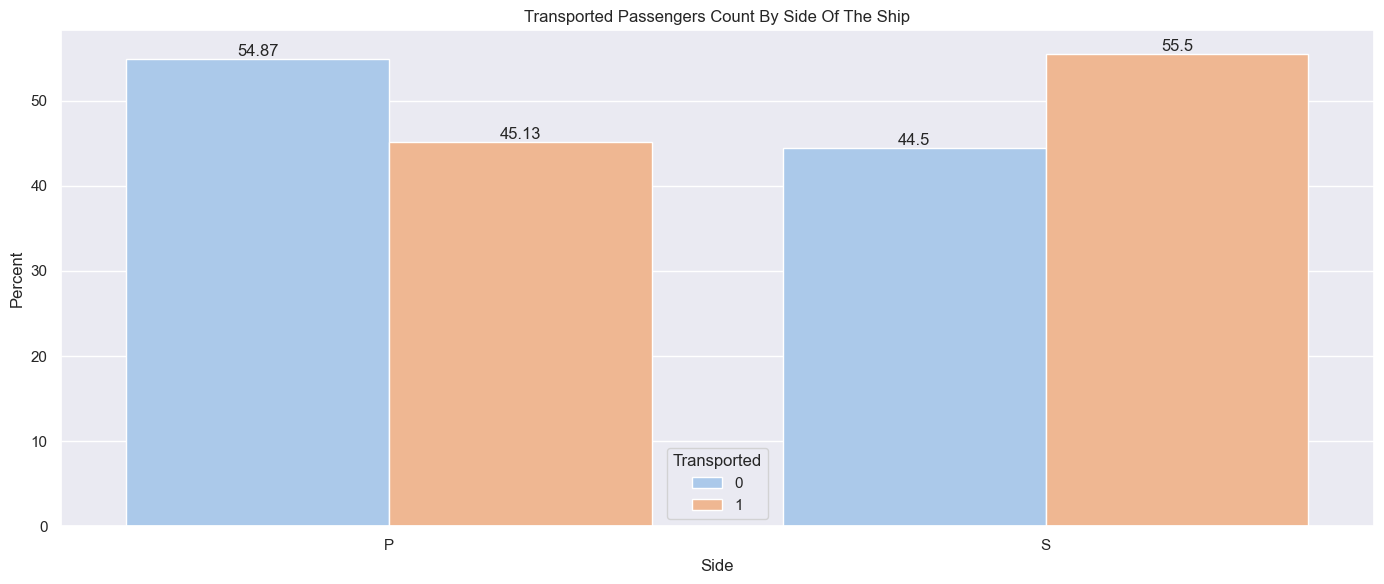

In [40]:
# Data preprocessing
effected_df = data_train[["Side", "Transported"]]
effected_df = effected_df.groupby(["Side", "Transported"])["Transported"].size().reset_index(name="Count")
total_counts = effected_df.groupby("Side")["Count"].transform("sum")
effected_df["Percent"] = round((effected_df["Count"] / total_counts) * 100, 2)

# Plot
ax = sns.barplot(data=effected_df, x="Side", y="Percent", hue="Transported")

for container in ax.containers:
    ax.bar_label(container)
    
plt.title("Transported Passengers Count By Side Of The Ship")
plt.tight_layout();

<li>As we can see, one side of the ship was effected more than the other.</li>

## Missing Values - Feature Engineering 

We always can fill missing values just with mean, mode or median, but let's step further and use insights from EDA. We fill train data first and use same method for test dataset.

### <b>Money spend</b>

For these columns, we will fill missing values with average of spending, while fill 0 to people younger than 13.

In [41]:
# Features which difines how much money was spended
features_spendings = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
print(f"Missing values before: \n{data_train[features_spendings].isnull().sum()}")

# Data mask
row_avg= data_train[features_spendings].mean(axis=1)
child_under_13_mask = data_train["Age"] < 13

# Handling missing values
for col in features_spendings:
    data_train[col] = data_train[col].where(~child_under_13_mask, 0)
    data_train[col] = data_train[col].fillna(row_avg)

print(f"Missing values after: \n{data_train[features_spendings].isnull().sum()}")

Missing values before: 
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64
Missing values after: 
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


#### Test data

In [42]:
# Data mask
row_avg= data_test[features_spendings].mean(axis=1)
child_under_13_mask = data_test["Age"] < 13

# Handling missing values
for col in features_spendings:
    data_test[col] = data_test[col].where(~child_under_13_mask, 0)
    data_test[col] = data_test[col].fillna(row_avg)

### <b>Cryo Sleep</b>

If a person didn't spend any money per travel, and he is traveling alone, it should be obvious that he is in cryosleep.

In [43]:
# New column for traveling alone
data_train["TravelingAlone"] = data_train["GroupSize"] == "01"
data_train["TravelingAlone"] = data_train["TravelingAlone"].astype(int)

In [44]:
print(f"Missing values after: {data_train["CryoSleep"].isnull().sum()}")

# Data mask
missing_cryo_sleep = data_train["CryoSleep"].isna()
spend_zero = data_train["SpentMoney"] == 0
spend_not_zero = data_train["SpentMoney"] == 1
group_size_one = data_train["TravelingAlone"] == 1

# Handling missing values
data_train.loc[missing_cryo_sleep & spend_zero & group_size_one, "CryoSleep"] = 1
data_train.loc[missing_cryo_sleep & spend_not_zero, "CryoSleep"] = 0

print(f"Missing values before: {data_train["CryoSleep"].isnull().sum()}")

Missing values after: 217
Missing values before: 40


If person is traveling with a group and other group members are in cryosleep,  than person should be also in cryosleep.

In [45]:
# Data mask
missing_cryo_sleep = data_train["CryoSleep"].isna()
group_spend_money = data_train["GroupSpentMoney"] == 0
group_size_not_one = data_train["GroupSize"] != "01"

# Handling missing values
data_train.loc[missing_cryo_sleep & group_spend_money & group_size_not_one, "CryoSleep"] = 1

print(f"Missing values before: {data_train["CryoSleep"].isnull().sum()}")

Missing values before: 29


For the last 29 people, we don't have an efficient way to will miss values. The best approach will be will with the mode of the group.

In [46]:
data_train = fill_missing_values_using_method(data_train, "GroupId", "CryoSleep", method="mode")
print(f"Missing values before: {data_train["CryoSleep"].isnull().sum()}")

Missing values before: 0


#### Test data

In [47]:
# New column for traveling alone
data_test["TravelingAlone"] = data_test["GroupSize"] == "01"
data_test["TravelingAlone"] = data_test["TravelingAlone"].astype(int)

# Data mask
missing_cryo_sleep = data_test["CryoSleep"].isna()
spend_zero = data_test["SpentMoney"] == 0
spend_not_zero = data_test["SpentMoney"] == 1
group_size_one = data_test["TravelingAlone"] == 1

# Handling missing values
data_test.loc[missing_cryo_sleep & spend_zero & group_size_one, "CryoSleep"] = 1
data_test.loc[missing_cryo_sleep & spend_not_zero, "CryoSleep"] = 0

# Data mask
missing_cryo_sleep = data_test["CryoSleep"].isna()
group_spend_money = data_test["GroupSpentMoney"] == 0
group_size_not_one = data_test["GroupSize"] != "01"

# Handling missing values
data_test.loc[missing_cryo_sleep & group_spend_money & group_size_not_one, "CryoSleep"] = 1
data_test = fill_missing_values_using_method(data_test, "GroupId", "CryoSleep", method="mode")

### <b>Home Planet</b>

If the person is traveling in a group, they are from the same planet.

In [48]:
print(f"Missing values before: {data_train["HomePlanet"].isnull().sum()}")
data_train = fill_missing_values_using_method(data_train, "GroupId", "HomePlanet", method="mode")
print(f"Missing values count: {data_train["HomePlanet"].isnull().sum()}")

Missing values before: 201
Missing values count: 111


Only people from Europe stays in A, B and C decks. For Earth is G.

In [49]:
# Data mask
mask_europe = pd.isna(data_train["HomePlanet"]) & data_train["Deck"].isin(["A", "B", "C"])
mask_earth = pd.isna(data_train["HomePlanet"]) & (data_train["Deck"] == "G")

# Handling missing values
data_train.loc[mask_europe, "HomePlanet"] = "Europa"
data_train.loc[mask_earth, "HomePlanet"] = "Earth"

print(f"Missing values before: {data_train["HomePlanet"].isnull().sum()}")

Missing values before: 64


Last Name bounds with Home Planet.

In [50]:
data_train = fill_missing_values_using_method(data_train, ["LastName"], "HomePlanet", method="mode")
print(f"Missing values count: {data_train["HomePlanet"].isnull().sum()}")

Missing values count: 8


Lastly, we will input last 8 missing value with most common over the Deck and Side.

In [51]:
data_train = fill_missing_values_using_method(data_train, ["Deck", "Side"], "HomePlanet", method="mode")
print(f"Missing values count: {data_train["HomePlanet"].isnull().sum()}")

Missing values count: 0


#### Test data

In [52]:
data_test = fill_missing_values_using_method(data_test, "GroupId", "HomePlanet", method="mode")

# Data mask
mask_europe = pd.isna(data_test["HomePlanet"]) & data_test["Deck"].isin(["A", "B", "C"])
mask_earth = pd.isna(data_test["HomePlanet"]) & (data_test["Deck"] == "G")

# Handling missing values
data_test.loc[mask_europe, "HomePlanet"] = "Europa"
data_test.loc[mask_earth, "HomePlanet"] = "Earth"

data_test = fill_missing_values_using_method(data_test, ["LastName"], "HomePlanet", method="mode")
data_test = fill_missing_values_using_method(data_test, ["Deck", "Side"], "HomePlanet", method="mode")

### <b>Destination</b>

As discussed in EDA, we have almost 90% of the group to have the same destination planet.

In [53]:
print(f"Missing values before: {data_train["Destination"].isnull().sum()}")
data_train = fill_missing_values_using_method(data_train, ["Deck", "CabinNumber", "Side"], "Destination", method="mode")
print(f"Missing values count: {data_train["Destination"].isnull().sum()}")

Missing values before: 182
Missing values count: 130


Now we can fill next values with mode of deck and side of ship.

In [54]:
data_train = fill_missing_values_using_method(data_train, ["Deck", "Side"], "Destination", method="mode")
print(f"Missing values count: {data_train["Destination"].isnull().sum()}")

Missing values count: 4


We get 4 values, let's inspect them.

For last values, we can fill them in 2 ways. First by grouping Last Name and Group Id. And if needed only by Group Id or Last Name.

In [55]:
data_train = fill_missing_values_using_method(data_train, ["GroupId", "LastName"], "Destination", method="mode")
print(f"Missing values count: {data_train["Destination"].isnull().sum()}")

Missing values count: 3


In [56]:
data_train = fill_missing_values_using_method(data_train, ["GroupId"], "Destination", method="mode")
print(f"Missing values count: {data_train["Destination"].isnull().sum()}")

Missing values count: 2


In [57]:
data_train = fill_missing_values_using_method(data_train, ["LastName"], "Destination", method="mode")
print(f"Missing values count: {data_train["Destination"].isnull().sum()}")

Missing values count: 0


#### Test Data

In [58]:
data_test = fill_missing_values_using_method(data_test, ["Deck", "CabinNumber", "Side"], "Destination", method="mode")
data_test = fill_missing_values_using_method(data_test, ["Deck", "Side"], "Destination", method="mode")
data_test = fill_missing_values_using_method(data_test, ["GroupId", "LastName"], "Destination", method="mode")
data_test = fill_missing_values_using_method(data_test, ["GroupId"], "Destination", method="mode")
data_test = fill_missing_values_using_method(data_test, ["LastName"], "Destination", method="mode")

### <b>Side</b>

We know that all people in group stay in one side of the ship.

In [59]:
print(f"Missing values before: {data_train["Side"].isnull().sum()}")
data_train = fill_missing_values_using_method(data_train, ["GroupId"], "Side", method="mode")
print(f"Missing values after: {data_train["Side"].isnull().sum()}")

Missing values before: 199
Missing values after: 99


We will fill next values using combination of Last Name and Side of ship.

In [60]:
data_train = fill_missing_values_using_method(data_train, ["LastName"], "Side", method="mode")
print(f"Missing values after: {data_train["Side"].isnull().sum()}")

Missing values after: 9


For last missing values, we will use mode of Home Planet and Destination Planet.

In [61]:
data_train = fill_missing_values_using_method(data_train, ["HomePlanet", "Destination"], "Side", method="mode")
print(f"Missing values after: {data_train["Side"].isnull().sum()}")

Missing values after: 0


#### Test Data

In [62]:
data_test = fill_missing_values_using_method(data_test, ["GroupId"], "Side", method="mode")
data_test = fill_missing_values_using_method(data_test, ["LastName"], "Side", method="mode")
data_test = fill_missing_values_using_method(data_test, ["HomePlanet", "Destination"], "Side", method="mode")

### <b>Deck</b>

For deck we will fill missing values base by Home Planet and Total Spening.

In [63]:
# Define the decks available for each HomePlanet
decks_by_homeplanet = {
    'Earth': ['E', 'F', 'G'],
    'Mars': ['D', 'E', 'F'],
    'Europa': ['A', 'B', 'C', 'D', 'E']
}

# Define dict spendings for each side
spendings_p_deck = spendings_per_deck.T["P"].to_dict()
spendings_s_deck = spendings_per_deck.T["S"].to_dict()


In [64]:
# As we use function only once we will leave it here.
def fill_deck(row: pd.Series):
    """
    Fills the Deck value in the dataframe based on row of the home planet, total spending, and side.

    Parameters:
    - row (pd.Series): A row from the DataFrame containing 'HomePlanet', 'TotalSpending', 'Side', and 'Deck'.

    Returns:
    - Union[str, float]: The closest deck based on the side and total spending, or the existing 'Deck' value.
                         Returns np.nan if 'Side' is neither 'S' nor 'P'.
    """
    h_planet = row["HomePlanet"]
    total_spending = row["TotalSpending"]
    side = row["Side"]

    possible_decks = decks_by_homeplanet.get(h_planet, [])

    if pd.isna(row["Deck"]):
        # Get the available decks for the homeplanet
        if side == "S":
            spend_mean = spendings_s_deck
        elif side == "P":
            spend_mean = spendings_p_deck
        else:
            return np.nan 

        # Find the closest deck based on total spending
        closest_deck = min(possible_decks, key=lambda deck: abs(spend_mean[deck] - total_spending))

        return closest_deck
    else:
        return row["Deck"]

In [65]:
print(f"Missing values before: {data_train["Deck"].isnull().sum()}")
data_train["Deck"] = data_train.apply(fill_deck, axis=1)
print(f"Missing values after: {data_train["Deck"].isnull().sum()}")

Missing values before: 199
Missing values after: 0


#### Test Data

In [66]:
# Define the decks available for each HomePlanet
decks_by_homeplanet = {
    'Earth': ['E', 'F', 'G'],
    'Mars': ['D', 'E', 'F'],
    'Europa': ['A', 'B', 'C', 'D', 'E']
}

# Define dict spendings for each side
spendings_p_deck = spendings_per_deck_test.T["P"].to_dict()
spendings_s_deck = spendings_per_deck_test.T["S"].to_dict()

# As we use function only once we will leave it here.
def fill_deck(row: pd.Series):
    """
    Fills the Deck value in the dataframe based on row of the home planet, total spending, and side.

    Parameters:
    - row (pd.Series): A row from the DataFrame containing 'HomePlanet', 'TotalSpending', 'Side', and 'Deck'.

    Returns:
    - Union[str, float]: The closest deck based on the side and total spending, or the existing 'Deck' value.
                         Returns np.nan if 'Side' is neither 'S' nor 'P'.
    """
    h_planet = row["HomePlanet"]
    total_spending = row["TotalSpending"]
    side = row["Side"]

    possible_decks = decks_by_homeplanet.get(h_planet, [])

    if pd.isna(row["Deck"]):
        # Get the available decks for the homeplanet
        if side == "S":
            spend_mean = spendings_s_deck
        elif side == "P":
            spend_mean = spendings_p_deck
        else:
            return np.nan 

        # Find the closest deck based on total spending
        closest_deck = min(possible_decks, key=lambda deck: abs(spend_mean[deck] - total_spending))

        return closest_deck
    else:
        return row["Deck"]

data_test["Deck"] = data_test.apply(fill_deck, axis=1)

### <b>CabinNumber</b>

As we saw strong relationship between group id and cabin features, we will use linear regression model to fill missing values.

In [67]:
print("Missing values before:", data_train["CabinNumber"].isnull().sum())

data_train["GroupId"] = data_train["GroupId"].astype(int)
decks = ["A", "B", "C", "D", "E", "F", "G"]

for deck in decks:
    deck_full_data = data_train[(data_train["Deck"] == deck) & (data_train["CabinNumber"].notnull())]
    x_full = deck_full_data["GroupId"]
    y_full = deck_full_data["CabinNumber"]
    x_full = x_full.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_full, y_full)
    deck_data_with_nan = data_train[(data_train["Deck"] == deck) & (data_train["CabinNumber"].isnull())]
    x_with_nan = deck_data_with_nan["GroupId"]
    x_with_nan = x_with_nan.values.reshape(-1, 1)

    if len(x_with_nan) > 0:
        predictions = model.predict(x_with_nan)
        rounded_predictions = np.round(predictions).astype(int)
        rounded_predictions = np.maximum(rounded_predictions, 1)
        data_train.loc[(data_train["Deck"] == deck) & (data_train["CabinNumber"].isnull()), "CabinNumber"] = rounded_predictions

print("Missing values after:", data_train["CabinNumber"].isnull().sum())

Missing values before: 199
Missing values after: 0


#### Test Data

In [68]:
data_test["GroupId"] = data_test["GroupId"].astype(int)

for deck in decks:
    deck_full_data = data_test[(data_test["Deck"] == deck) & (data_test["CabinNumber"].notnull())]
    x_full = deck_full_data["GroupId"]
    y_full = deck_full_data["CabinNumber"]
    x_full = x_full.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_full, y_full)
    deck_data_with_nan = data_test[(data_test["Deck"] == deck) & (data_test["CabinNumber"].isnull())]
    x_with_nan = deck_data_with_nan["GroupId"]
    x_with_nan = x_with_nan.values.reshape(-1, 1)

    if len(x_with_nan) > 0:
        predictions = model.predict(x_with_nan)
        rounded_predictions = np.round(predictions).astype(int)
        rounded_predictions = np.maximum(rounded_predictions, 1)
        data_test.loc[(data_test["Deck"] == deck) & (data_test["CabinNumber"].isnull()), "CabinNumber"] = rounded_predictions

### <b>Age</b>

For the age we fill combine home planet, cryo sleep, spent money and traveling alone features to get median of their groups.

In [69]:
print(f"Missing values before: {data_train["Age"].isnull().sum()}")
data_train = fill_missing_values_using_method(data_train, ["HomePlanet","CryoSleep", "SpentMoney", "TravelingAlone"], "Age", method="median")
print(f"Missing values count: {data_train["Age"].isnull().sum()}")

Missing values before: 179
Missing values count: 0


Base by EDA we can create age clusters.

In [70]:
# Define bins
bins = [0, 13, 18, 25, 30, 40, 50, float("inf")] # N
labels = ["0 - 13", "14 - 18", "19 - 25", "26 - 30", "31 - 40", "41 - 50", "51+"] 

# Creating new columns
data_train["AgeGroup"] = pd.cut(data_train["Age"], bins=bins, labels=labels, right=False)
data_test["AgeGroup"] = pd.cut(data_test["Age"], bins=bins, labels=labels, right=False)

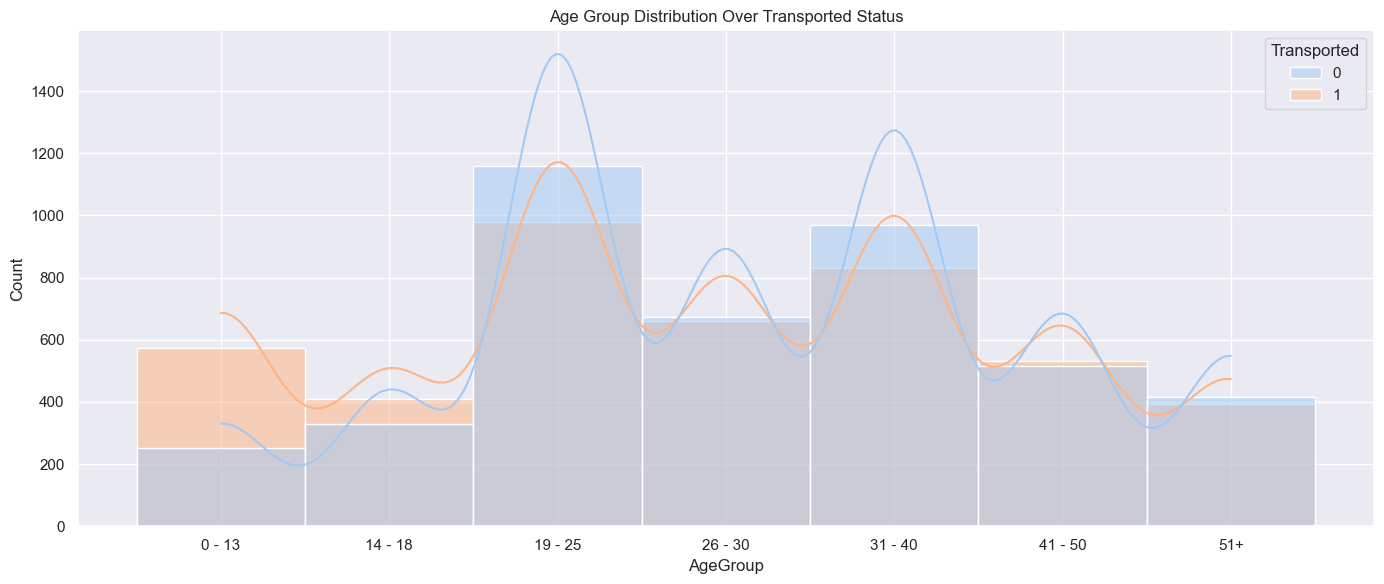

In [71]:
# Plot
fig = sns.histplot(data=data_train, x="AgeGroup", hue="Transported", kde=True)
plt.title("Age Group Distribution Over Transported Status")
plt.tight_layout();

<li>Group 0–13 and 14-18 show that they have more people transported than not.</li>
<li>In group 19-25 and 31-40, we can see that both of them have higher chance to be not transported.</li>
<li>Groups 26-30, 41-50 and 51+ show that there are almost equal chance to be transported and not.</li>

#### Test Data

In [72]:
data_test = fill_missing_values_using_method(data_test, ["HomePlanet","CryoSleep", "SpentMoney", "TravelingAlone"], "Age", method="median")
data_test["AgeGroup"] = pd.cut(data_test["Age"], bins=bins, labels=labels, right=False)

### <b>VIP</b>

During EDA, we make a decision to drop this feature as it not giving us any useful information.

In [73]:
data_train = data_train.drop(columns=["VIP"])

#### Test Data

In [74]:
data_test = data_test.drop(columns=["VIP"])

### <b>Last Name, First name</b>

We can drop Last Name, as it only was used for filling the data.

In [75]:
data_train = data_train.drop(columns=["LastName"])

#### Test Data

In [76]:
data_test = data_test.drop(columns=["LastName"])

### <b>Missing Values Check</b>

In [77]:
data_train.isnull().sum().any()

False

#### Test Data

In [78]:
data_test.isnull().sum().any()

False

### Additional tunning

We are removing Deck T which is outlier for us to increase our model performance.

In [79]:
data_train = data_train[data_train["Deck"] != "T"]

## Modelling

Split our data_train dataset to train and valid datasets, but before than we will split it to data and target.

In [80]:
# Split data to target and features
y = data_train["Transported"]
x = data_train.drop(columns=["Transported"])

# Split data to test and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In EDA step, we saw that some of the features have widely scaled, so we will use StandardScaler to standardize features by removing the mean and scaling to unit variance. We also use OrdinalEncoder to encode categorical features as an integer array and OrdinalEncoder as we have features which provides order. We will wrap those steps to pipeline to make our models scalable.

In [81]:
# Selecting features
num_features = ["GroupSize", "Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpending"]
cat_features = ["HomePlanet", "CryoSleep", "CabinNumber", "Side", "Destination", "TravelingAlone", "SpentMoney", "GroupSpentMoney"]
ord_features = ["Deck", "AgeGroup"]

In [82]:
# Creating pipelines with transformer
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Ensure sparse=False
    ])

ord_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_transformer, num_features), 
        ("categorical", cat_transformer, cat_features),
        ("ordinal", ord_transformer, ord_features)
    ])

As we prepared pipelines for the model, first we need to create a baseline for the model, for this we will use Dummy Classifier which will predict most frequent class using simple strategies. 

In [83]:
# Dummy model
dummy_model = DummyClassifier(strategy="most_frequent")

# Dummy pipeline
dummy_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("model", dummy_model)])

# Fitting dummy model with data
dummy_pipeline.fit(x_train, y_train)

# Making baseline predictions
dummy_predictions = dummy_pipeline.predict(x_valid)

In [84]:
# Accuracy score for dummy classifier
cm = accuracy_score(y_valid, dummy_predictions)
cm

0.502301495972382

We set our baseline accuracy for the model, it is little better than random guessing.

### Feature Selection

For selecting top features which is important for us, we will use Boruta algorithm.

<li>It creates shadow features - random features and shuffle values in columns.</li>
<li>Model use train base model to calculate feature importance.</li>
<li>It checks if real features have higher importance than shadow features</li>

In [85]:
# Create boruta pipeline
boruta_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=20))
])

# Fit the pipeline
boruta_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GroupSize', 'Age',
                                                   'RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalSpending']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode...
                                                                                 sparse_output=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'CabinNumber', 'Side',
                                                   'Destination',
                                                   'TravelingAlone',
                                                   'SpentMoney',
                                                   'GroupSpentMoney']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Deck', 'AgeGroup'])])),
                ('model', RandomForestClassifier(random_state=20))])

In [86]:
# Model for boruta predictions
boruta_model = XGBClassifier(random_state=42)
feat_selector = BorutaPy(boruta_model, n_estimators="auto", verbose=2, random_state=42)

# Apply preprocessing to x_train
x_train_preprocessed = boruta_pipeline.named_steps["preprocessor"].transform(x_train)

# Convert to dense matrix if it's sparse
if hasattr(x_train_preprocessed, "toarray"): # method returns true if an object has the given named attribute and false if it does not
    x_train_preprocessed = x_train_preprocessed.toarray()

# Fit BorutaPy
feat_selector.fit(x_train_preprocessed, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1763
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	1752
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	9
Rejected: 	1752
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	9
Rejected: 	1752
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	9
Rejected: 	1752
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	7
Rejected: 	1754
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	7
Rejected: 	1754
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	7
Rejected: 	1754
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	7
Rejected: 	1754
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=40,
                                 n_jobs=None, num_parallel_tree=None,
                                 random_state=1577545149, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x171C8F7BA40, verbose=2)

In [87]:
# Retrieve the important features
important_features = feat_selector.support_

# Create list of features which is important for us
feature_names = np.array(x_train.columns)

# Print the results
feature_ranks = list(zip(feature_names, feat_selector.ranking_, feat_selector.support_))
feature_ranks = pd.DataFrame(feature_ranks)
feature_ranks.sort_values(by=[1]).T

,9,3,7,8,11,6,5,4,2,10,1,0,13,12,14,15,16,17,18
0,RoomService,CryoSleep,Destination,Age,ShoppingMall,Side,CabinNumber,Deck,HomePlanet,FoodCourt,GroupSize,GroupId,VRDeck,Spa,TotalSpending,SpentMoney,GroupSpentMoney,TravelingAlone,AgeGroup
1,1,1,1,1,1,7,10,11,18,24,33,43,95,931,931,931,931,931,931
2,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


We get most important feature for us, but model show that a lot of are not important for us, so we will consider of using Boruta if main model performs not good enough

In [88]:
# Selecting boruta features
num_features_boruta = ["GroupSize", "Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "TotalSpending",]
cat_features_boruta = ["HomePlanet", "CryoSleep", "CabinNumber", "Side", "Destination"]
ord_features_boruta = ["Deck"]

In [89]:
boruta_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_transformer, num_features_boruta), 
        ("categorical", cat_transformer, cat_features_boruta),
        ("ordinal", ord_transformer, ord_features_boruta)
    ])

### Model Selection

Okay, we get our threshold, which will be our baseline for models.

We already imported ML models and parameters from machine_learning_models file, so we can proceed further to combining our models and geting the results, also we will use RandomizedSearchCV which will perform most of the Hyperparameter tuning for us and finally fit our models and check results of them.

We will use 3 models:

<b>LogisticRegression</b>

<li>Logistic Regression is a straightforward model that is easy to understand and interpret. It provides clear insights into feature importance through its coefficients.</li>
<li>With the class_weight='balanced' parameter, Logistic Regression can handle class imbalance by adjusting the weights inversely proportional to class frequencies.</li>

<b>RandomForestClassifier</b>

<li>Random Forest is an ensemble method that combines multiple decision trees to improve accuracy and robustness, reducing the risk of overfitting compared to individual decision trees.</li>
<li>By setting class_weight='balanced', Random Forest can mitigate the impact of class imbalance.</li>

<b>GradientBoostingClassifier</b>

<li>Gradient Boosting often provides state-of-the-art performance on structured/tabular data due to its iterative boosting process that reduces bias and variance.</li>
<li>It allows for fine-tuning through various hyperparameters (e.g., learning rate, number of estimators, max depth), providing flexibility to balance bias-variance trade-off.</li>

<b>XGBoost</b>

<li>XGBoost is well-known for the model speed and performance.</li>
<li>L1 and L2 regularization  prevents overfitting, making it a powerful choice for predictive modeling.</li>

<b>K-Nearest Neighbors (KNN)</b>

<li>KNN is a simple model that makes predictions based on the biggest class per k-nearest neighbors.</li>
<li>It’s non-parametric, meaning it makes fewer assumptions about the data distribution.</li>
<li>Highly effective for smaller datasets</li>

<b>Light Gradient Boosting Machine (LGBM)</b>

<li>LGBM is fast model having high training speed and high efficiency</li>
<li>Model handles categorical columns and provides high combinations of hyperparameter tuning.</li>



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       865
           1       0.77      0.80      0.78       873

    accuracy                           0.78      1738
   macro avg       0.78      0.78      0.78      1738
weighted avg       0.78      0.78      0.78      1738

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Random Forest
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       865
           1       0.80      0.77      0.78       873

    accuracy                           0.78      1738
   macro avg       0.78      0.78      0.78      1738
weighted avg       0.78      0.78      0.78      1738

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Gradient Boosting
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       865
     

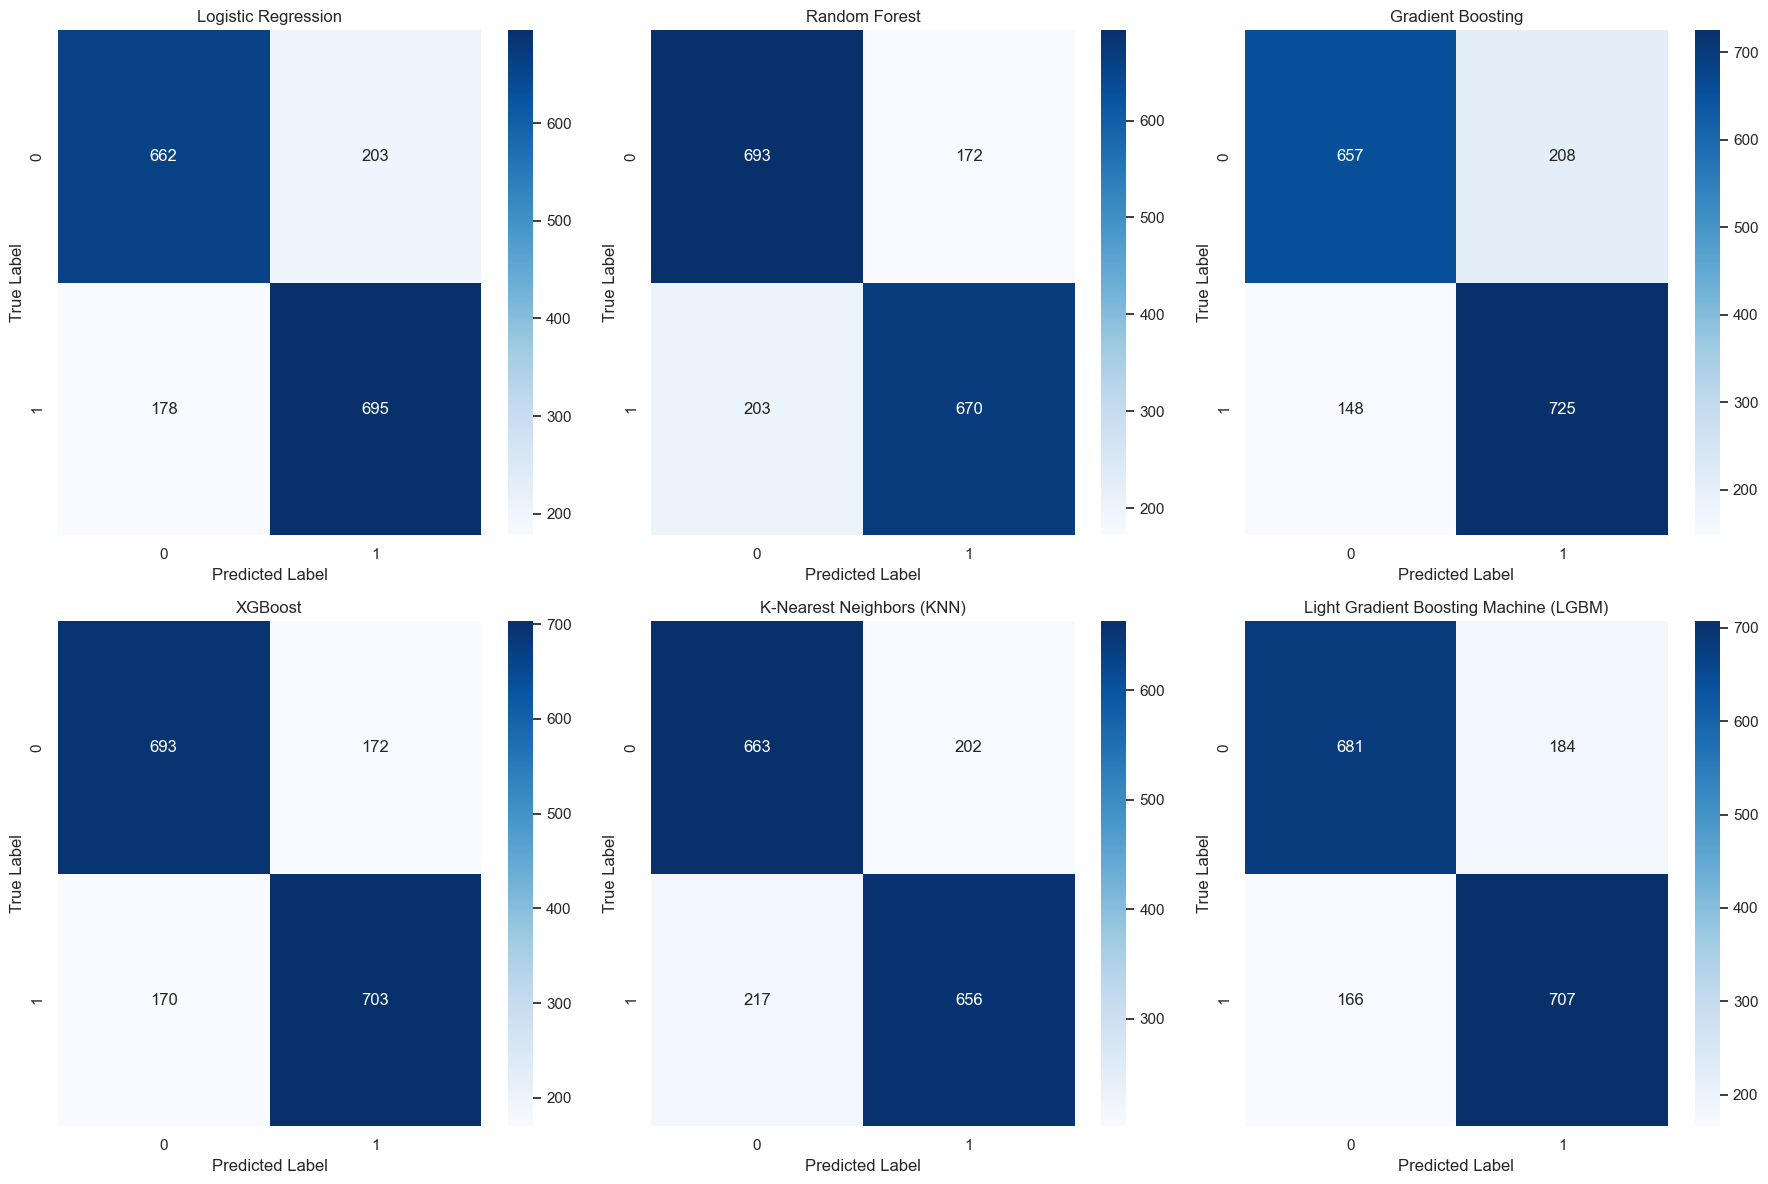

In [90]:
# Plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Prediction
results = []
place = 0
for i, (model_name, model) in enumerate(ml_models.items()):
    # Create a pipeline that combines preprocessing with the model
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # Load Hyperparameters for model
    param_grid = ml_models_parameters[model_name]

    # Perform Hyperparameter search
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=min(10, len(param_grid)),
        cv=5, # Cross validation
        verbose=1, # Parameter print
        random_state=42,
        n_jobs=-1
    )
    
    # Calculate time for fiting of model
    start_time = time.time()
    search.fit(x_train, y_train)
    end_time = time.time()

    # Get best model parameters and evaluate it
    best_model = search.best_estimator_
    best_score = search.best_score_
    y_pred = best_model.predict(x_valid)

    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    # Store results
    results.append({
        "Model": model_name,
        "Best Parameters": search.best_params_,
        "Best Score": best_score,
        "Test Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": cm,
        "Time Taken (seconds)": end_time - start_time
    })
    print(model_name)
    print(classification_report(y_valid, y_pred))
    cm_matrix(cm=cm, place=i, model_name=model_name, axes=axes)
    place += 1

plt.tight_layout()
results_df = pd.DataFrame(results)

In [91]:
results_df = results_df.sort_values(by=["Test Accuracy", "F1 Score"], ascending=False)
results_df

,Model,Best Parameters,Best Score,Test Accuracy,Precision,Recall,F1 Score,Confusion Matrix,Time Taken (seconds)
3,XGBoost,"{'model__subsample': 0.7, 'model__n_estimators...",0.803165,0.803222,0.803429,0.805269,0.804348,"[[693, 172], [170, 703]]",21.084696
5,Light Gradient Boosting Machine (LGBM),"{'model__subsample': 0.5, 'model__num_leaves':...",0.802302,0.798619,0.793490,0.809851,0.801587,"[[681, 184], [166, 707]]",6.790060
2,Gradient Boosting,"{'model__n_estimators': 100, 'model__max_depth...",0.799712,0.795167,0.777063,0.830470,0.802879,"[[657, 208], [148, 725]]",132.701979
1,Random Forest,"{'model__n_estimators': 200, 'model__min_sampl...",0.794101,0.784235,0.795724,0.767468,0.781341,"[[693, 172], [203, 670]]",20.271303
0,Logistic Regression,"{'model__penalty': 'l2', 'model__max_iter': 10...",0.786187,0.780783,0.773942,0.796105,0.784867,"[[662, 203], [178, 695]]",6.288605
4,K-Nearest Neighbors (KNN),"{'model__weights': 'distance', 'model__n_neigh...",0.774676,0.758918,0.764569,0.751432,0.757943,"[[663, 202], [217, 656]]",17.631506


### Final Model

In [92]:
# Remove model__ from dict in the column rows
results_df["Best Parameters"] = results_df["Best Parameters"].apply(
    lambda d: 
    {k.replace("model__", ""): 
     v for k, v in d.items() 
     if isinstance(k, str)}
)


In [93]:
# Sort the DataFrame by Test Accuracy or your preferred metric
best_model_row = results_df.loc[results_df["Test Accuracy"].idxmax()]
model_name = best_model_row["Model"]
best_params = best_model_row["Best Parameters"]

In [94]:
# Extract the model class from the dictionary
best_model_class = ml_models[model_name]

In [95]:
# Reconstruct the best model pipeline with its parameters
best_model = Pipeline([
    ("preprocessor", preprocessor),  
    ("model", best_model_class.set_params(**best_params))
])

# Fit the best model pipeline on the entire training data
best_model.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GroupSize', 'Age',
                                                   'RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck', 'TotalSpending']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

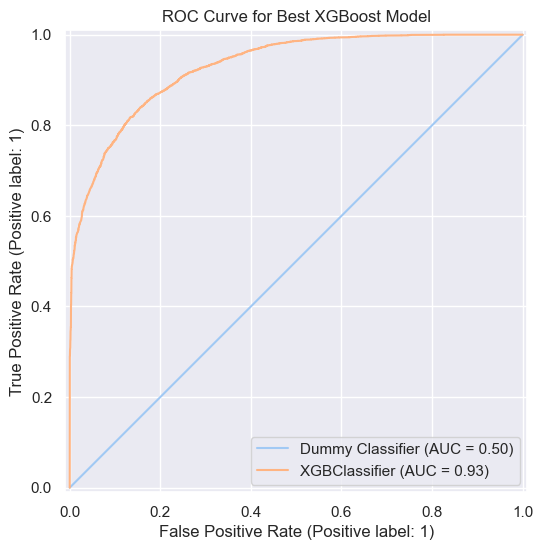

In [96]:
# Preprocess the data
x_preprocessed = preprocessor.fit_transform(x)

# Plot ROC
fig, ax = plt.subplots()

# ROC for Dummy Classifier
RocCurveDisplay.from_estimator(dummy_pipeline, x_valid, y_valid, ax=ax, name="Dummy Classifier")

# Plot ROC for the best model
RocCurveDisplay.from_estimator(best_model.named_steps["model"], x_preprocessed, y, ax=ax)

# Add labels and title
plt.title(f'ROC Curve for Best {model_name} Model')
plt.show()

We see that the best model curve lies way more above than the Dummy Classifier line, this indicates that the model is performing way better than random guessing.

In [97]:
# Cross-validation with the Best Model
cv_scores = cross_val_score(
    best_model, 
    x, y, cv=10, 
    scoring="roc_auc")

print(f"Cross-validated ROC-AUC: {np.mean(cv_scores):.4f}")

Cross-validated ROC-AUC: 0.8905


In [98]:
# Predictions on Test Data
x_data_test = data_test
x_data_test_preprocessed = preprocessor.transform(x_data_test)

In [99]:
# Make predictions using the best model
y_pred = best_model.predict(x_data_test)

In [100]:
# Convert GroupId and GroupSize to strings and filling missing 0 in the front of string
data_test["GroupId"] = data_test["GroupId"].astype(str)
data_test["GroupId"] = data_test["GroupId"].str.zfill(4)

data_test["GroupSize"] = data_test["GroupSize"].astype(str)
data_test["GroupSize"] = data_test["GroupSize"].str.zfill(2)

In [101]:
# Concatenate formatted 'GroupId' and 'GroupSize' with an underscore
data_test["PassengerId"] = data_test["GroupId"] + '_' + data_test["GroupSize"]

In [102]:
# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "PassengerId": data_test["PassengerId"],
    "Transported": (y_pred > 0.5).astype(bool)
})

In [103]:
# Save the predictions for submission
submission_df.to_csv("data/submission.csv", index=False)
joblib.dump(best_model, "ml_models/best_model.pkl")

['ml_models/best_model.pkl']

### AutoML Model

In [104]:
# Start H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from E:\Programs\Python\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Ricka\AppData\Local\Temp\tmp76jgp4rr
  JVM stdout: C:\Users\Ricka\AppData\Local\Temp\tmp76jgp4rr\h2o_Ricka_started_from_python.out
  JVM stderr: C:\Users\Ricka\AppData\Local\Temp\tmp76jgp4rr\h2o_Ricka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Helsinki
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_Ricka_3mzms1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.070 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [105]:
# Loading data
data_train_h2o = h2o.H2OFrame(data_train)
data_test_h2o = h2o.H2OFrame(data_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [106]:
# Define target and features
target = "Transported"
features_for_automl = data_train_h2o.columns
features_for_automl.remove(target)  # Remove the target from features list

In [107]:
# Convert target to a factor if it's a classification problem
data_train_h2o[target] = data_train_h2o[target].asfactor()

In [108]:
# Split the dataset into train and valid sets for automl
train, valid = data_train_h2o.split_frame(ratios=[.8], seed=1234)

In [109]:
# Train the AutoML model
aml = H2OAutoML(
    max_runtime_secs=600,   # Run AutoML for x seconds
    stopping_metric="AUC",  # Use AUC as the early stopping metric
    balance_classes=True,   # Balance classes in case of class imbalance
    seed=1234,              # Set seed for reproducibility
    nfolds=5,               # Use 5-fold cross-validation
    keep_cross_validation_predictions=True # Keep CV predictions for further use

)
aml.train(x=features_for_automl, y=target, training_frame=train, validation_frame=valid)

AutoML progress: |
20:10:43.534: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:10:43.539: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/66
# GBM base models (used / total),6/32
# DeepLearning base models (used / total),7/31
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [110]:
# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head())

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_Best1000_1_AutoML_1_20240906_201043      0.898159   0.392788  0.910281                0.197463  0.358028  0.128184
StackedEnsemble_AllModels_6_AutoML_1_20240906_201043     0.898093   0.393125  0.91038                 0.197157  0.358178  0.128292
StackedEnsemble_BestOfFamily_6_AutoML_1_20240906_201043  0.898093   0.394073  0.909755                0.198159  0.358431  0.128473
StackedEnsemble_AllModels_4_AutoML_1_20240906_201043     0.898012   0.393321  0.910317                0.196389  0.358244  0.128339
StackedEnsemble_BestOfFamily_4_AutoML_1_20240906_201043  0.897847   0.394479  0.909547                0.202153  0.358607  0.128599
StackedEnsemble_AllModels_3_AutoML_1_20240906_201043     0.897724   0.394013  0.910416                0.198643  0.358494  0.128518
StackedEnsemble_AllModels_1_AutoML_1_20240906_201043     0.896157   0.398888  0.907

In [111]:
# Get the best model (leader model)
best_model = aml.leader

In [112]:
# Make predictions on the valid set
predictions = best_model.predict(valid)
print(predictions.head())

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
  predict          p0        p1
        0  0.983436    0.016564
        1  0.00611091  0.993889
        1  0.432301    0.567699
        0  0.859335    0.140665
        1  0.00997995  0.99002
        1  0.393053    0.606947
        0  0.882654    0.117346
        1  0.295063    0.704937
        1  0.356404    0.643596
        0  0.827529    0.172471
[10 rows x 3 columns]



In [113]:
# Evaluate the model
perf = best_model.model_performance(valid)
print(perf)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.11823955763380163
RMSE: 0.3438597935697072
LogLoss: 0.3648848559548313
AUC: 0.913577076709872
AUCPR: 0.9257279212093938
Gini: 0.827154153419744
Null degrees of freedom: 1715
Residual degrees of freedom: 1702
Null deviance: 2378.6542378764602
Residual deviance: 1252.284825636981
AIC: 1280.284825636981

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41270991477834196
       0    1    Error    Rate
-----  ---  ---  -------  --------------
0      655  191  0.2258   (191.0/846.0)
1      105  765  0.1207   (105.0/870.0)
Total  760  956  0.1725   (296.0/1716.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.41271      0.837897  220
max f2                       0.261424     0.889904  274
max f0point5                 0.678021     0.859902  119
max ac

In [114]:
# Extract parameters of the best model
model_params = best_model.params

# Print all parameters and their values
for param_name, param_value in model_params.items():
    print(f"{param_name}: {param_value["actual"]}")

model_id: {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'StackedEnsemble_Best1000_1_AutoML_1_20240906_201043', 'type': 'Key<Model>', 'URL': '/3/Models/StackedEnsemble_Best1000_1_AutoML_1_20240906_201043'}
training_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20240906_201043_training_py_3_sid_80f3', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20240906_201043_training_py_3_sid_80f3'}
response_column: {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'Transported', 'is_member_of_frames': None}
validation_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_4_sid_80f3', 'type': 'Key<Frame>', 'URL': '/3/Frames/py_4_sid_80f3'}
blending_frame: None
base_models: [{'__meta': {'schema_version': 3, 'schema_name': 'KeyV3', 'schema_type': 'Key<Keyed>'

In [115]:
# Make predictions on the test set
predictions = best_model.predict(data_test_h2o).as_data_frame()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [116]:
# Combine GroupId and GroupSize to create PassengerId
data_test["PassengerId"] = data_test["GroupId"].astype(str) + '_' + data_test["GroupSize"].astype(str)

In [117]:
# Map predictions 
predictions["Transported"] = (predictions["p1"] > 0.5).astype(bool)

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "PassengerId": data_test["PassengerId"],
    "Transported": predictions["Transported"] 
})


In [118]:
# Save the predictions for submission
submission_df.to_csv('data/submission_automl.csv', index=False)

In [119]:
# Shutdown H2O cluster
h2o.shutdown(prompt=False)

H2O session _sid_80f3 closed.


## Summary

<li>PassengerId split into GroupId and GroupSize.</li>
<li>VIP column was removed as it not giving us any useful information.</li>
<li>Filled missing values for both train and test datasets using various methods based on EDA analysis.</li>
<li>CryoSleep and SpentMoney show medium correlation with the target.</li>
<li>Numeric features show medium to low correlation.</li>
<li>Data is highly balanced.</li>
<li>One Home Planet per Family.</li>
<li>Most cabins stay at Decks E, F, and G, while cabin T shows an outlier.</li>
<li>Distribution over both decks is similar for Home Planet and Destination.</li>
<li>All people in groups stay on one side of the ship.</li>
<li>About ~91% of the cabins have only one destination planet.</li>
<li>35.8% of people on the ship are in cryosleep, 64.2% are awake.</li>
<li>Filled missing values of Cabin Number using a linear regression model.</li>
<li>High outliers with spending features, capped maximum values at the 0.95 quantile.</li>
<li>People with age 12 and lower didn't spend money at all.</li>
<li>Most outliers stay with older people, who also spend the most.</li>
<li>The age distribution is skewed to the right, indicating a longer tail on the right side.</li>
<li>Based on overlapping distribution, it looks like younger people get transported more than older.</li>
<li>Additional bins created for age groups.</li>
<li>All groups have only one unique Home planet.</li>
<li>Reject the null hypothesis: There is a significant association between spaceship side and transported status.</li>
<li>Created ML Dummy Classifier model for baseline.</li>
<li>Used Boruta to check feature importance.</li>
<li>Created multiple ML models while evaluating which is the best based on F1 score and accuracy.</li>
<li>Used the best model to tune it a little bit more, evaluate it using the ROC curve, and predict results.</li>
<li>Created AutoML model, ran it for 10 minutes, to check its performance.</li>
<li>Submitted the best predictions to Kaggle competition - with the best accuracy of 0.80819 with manual ML model.</li>
<li>AutoMl model scored 0.80102 accuracy, which is almost the same.</li>

## Suggestion For Improvement

<li>Try ensemble methods that combine the strengths of different models.</li>
<li>Check feature importance using SHAP.</li>